# GM-VAE for KI

In [1]:
num_epochs=10000
num_components=2  # only the starting number of components

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/yangz2/projects/modules/')
from log_training_progress import email_training_progress

## Load data

In [3]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [4]:
chunks_int = open_json_as_nparray('/home/yangz2/projects/gmvae_and_gmmvae/data/kia_chunks_int.json')
chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
chunks_onehot.shape

(1142, 16, 16, 7)

In [5]:
chunks_onehot = chunks_onehot.reshape(
    chunks_onehot.shape[0], 
    chunks_onehot.shape[1] * chunks_onehot.shape[2] * chunks_onehot.shape[3]
)
chunks_onehot.shape

(1142, 1792)

In [6]:
def get_random_labels(num_components, size):
    return np.random.randint(num_components, size=size)

## Input Parameters

In [7]:
num_components = 8

In [8]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=1792, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=1, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [9]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [10]:
def get_train_dl_and_valid_dl(chunks, labels):

    valid_indices = np.random.randint(len(chunks), size=100)
    train_chunks, valid_chunks = chunks, chunks[valid_indices]
    train_labels, valid_labels = labels, labels[valid_indices]

    train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
    valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

    train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)
    
    return train_dl, valid_dl

## Train Model

In [11]:
email_training_progress('Training starts!')
for num_components in [4]:
    
    args.num_classes = num_components
    gmvae = GMVAE(args)
    
    labels = get_random_labels(num_components, len(chunks_onehot))
    train_dl, valid_dl = get_train_dl_and_valid_dl(chunks_onehot, labels)
    gmvae.train(train_dl, valid_dl)
    
    torch.save(
        gmvae.network.state_dict(),
        f'../qualitative_clustering_analysis/kia_gmvae_{num_components}_{num_epochs}.pth'
    )
    
    email_training_progress(f'GM-VAE with {num_components} components has finished training!')
email_training_progress('Shutdown VM now!')

(Epoch 1 / 10000) Train_Loss: 671.134; Val_Loss: 454.721   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.309; Val_NMI: 4.244
(Epoch 2 / 10000) Train_Loss: 452.335; Val_Loss: 445.571   Train_ACC: 27.058; Val_ACC: 36.000   Train_NMI: 0.232; Val_NMI: 5.220
(Epoch 3 / 10000) Train_Loss: 446.534; Val_Loss: 441.630   Train_ACC: 27.408; Val_ACC: 37.000   Train_NMI: 0.530; Val_NMI: 7.852
(Epoch 4 / 10000) Train_Loss: 444.453; Val_Loss: 439.919   Train_ACC: 26.708; Val_ACC: 40.000   Train_NMI: 0.140; Val_NMI: 7.225
(Epoch 5 / 10000) Train_Loss: 443.954; Val_Loss: 439.580   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.345; Val_NMI: 4.188
(Epoch 6 / 10000) Train_Loss: 442.866; Val_Loss: 438.965   Train_ACC: 26.007; Val_ACC: 31.000   Train_NMI: 0.104; Val_NMI: 0.728
(Epoch 7 / 10000) Train_Loss: 440.766; Val_Loss: 432.804   Train_ACC: 27.496; Val_ACC: 36.000   Train_NMI: 0.286; Val_NMI: 2.610
(Epoch 8 / 10000) Train_Loss: 431.892; Val_Loss: 423.280   Train_ACC: 26.532; Val_ACC: 35.000   T

(Epoch 65 / 10000) Train_Loss: 343.924; Val_Loss: 343.603   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.234; Val_NMI: 4.550
(Epoch 66 / 10000) Train_Loss: 343.371; Val_Loss: 343.045   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.311; Val_NMI: 4.217
(Epoch 67 / 10000) Train_Loss: 342.442; Val_Loss: 342.841   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 3.999
(Epoch 68 / 10000) Train_Loss: 340.857; Val_Loss: 340.011   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.195; Val_NMI: 4.179
(Epoch 69 / 10000) Train_Loss: 339.891; Val_Loss: 341.567   Train_ACC: 26.795; Val_ACC: 33.000   Train_NMI: 0.277; Val_NMI: 4.128
(Epoch 70 / 10000) Train_Loss: 337.923; Val_Loss: 338.223   Train_ACC: 26.620; Val_ACC: 34.000   Train_NMI: 0.177; Val_NMI: 4.942
(Epoch 71 / 10000) Train_Loss: 336.593; Val_Loss: 335.826   Train_ACC: 26.883; Val_ACC: 33.000   Train_NMI: 0.233; Val_NMI: 6.171
(Epoch 72 / 10000) Train_Loss: 335.564; Val_Loss: 338.542   Train_ACC: 27.233; Val_ACC: 33

(Epoch 128 / 10000) Train_Loss: 254.696; Val_Loss: 252.946   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.273; Val_NMI: 3.734
(Epoch 129 / 10000) Train_Loss: 251.598; Val_Loss: 253.011   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.265; Val_NMI: 3.683
(Epoch 130 / 10000) Train_Loss: 251.481; Val_Loss: 251.312   Train_ACC: 27.058; Val_ACC: 36.000   Train_NMI: 0.221; Val_NMI: 6.072
(Epoch 131 / 10000) Train_Loss: 249.992; Val_Loss: 254.385   Train_ACC: 26.883; Val_ACC: 33.000   Train_NMI: 0.202; Val_NMI: 3.857
(Epoch 132 / 10000) Train_Loss: 251.277; Val_Loss: 250.914   Train_ACC: 26.795; Val_ACC: 35.000   Train_NMI: 0.244; Val_NMI: 3.666
(Epoch 133 / 10000) Train_Loss: 249.733; Val_Loss: 250.388   Train_ACC: 26.795; Val_ACC: 34.000   Train_NMI: 0.238; Val_NMI: 3.016
(Epoch 134 / 10000) Train_Loss: 249.621; Val_Loss: 249.661   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.287; Val_NMI: 3.990
(Epoch 135 / 10000) Train_Loss: 245.414; Val_Loss: 241.000   Train_ACC: 27.145; Val

(Epoch 191 / 10000) Train_Loss: 169.340; Val_Loss: 165.632   Train_ACC: 26.708; Val_ACC: 34.000   Train_NMI: 0.232; Val_NMI: 4.018
(Epoch 192 / 10000) Train_Loss: 170.872; Val_Loss: 159.959   Train_ACC: 27.058; Val_ACC: 38.000   Train_NMI: 0.238; Val_NMI: 5.322
(Epoch 193 / 10000) Train_Loss: 168.172; Val_Loss: 161.847   Train_ACC: 27.145; Val_ACC: 35.000   Train_NMI: 0.259; Val_NMI: 4.192
(Epoch 194 / 10000) Train_Loss: 168.769; Val_Loss: 159.243   Train_ACC: 27.233; Val_ACC: 37.000   Train_NMI: 0.267; Val_NMI: 6.139
(Epoch 195 / 10000) Train_Loss: 166.124; Val_Loss: 157.633   Train_ACC: 27.058; Val_ACC: 37.000   Train_NMI: 0.281; Val_NMI: 5.253
(Epoch 196 / 10000) Train_Loss: 165.081; Val_Loss: 154.345   Train_ACC: 27.233; Val_ACC: 37.000   Train_NMI: 0.263; Val_NMI: 5.253
(Epoch 197 / 10000) Train_Loss: 162.684; Val_Loss: 152.463   Train_ACC: 26.708; Val_ACC: 38.000   Train_NMI: 0.240; Val_NMI: 5.431
(Epoch 198 / 10000) Train_Loss: 162.137; Val_Loss: 154.886   Train_ACC: 26.708; Val

(Epoch 254 / 10000) Train_Loss: 117.082; Val_Loss: 106.268   Train_ACC: 27.320; Val_ACC: 39.000   Train_NMI: 0.320; Val_NMI: 5.096
(Epoch 255 / 10000) Train_Loss: 117.584; Val_Loss: 109.213   Train_ACC: 27.671; Val_ACC: 37.000   Train_NMI: 0.433; Val_NMI: 4.079
(Epoch 256 / 10000) Train_Loss: 116.846; Val_Loss: 107.307   Train_ACC: 26.970; Val_ACC: 34.000   Train_NMI: 0.313; Val_NMI: 4.523
(Epoch 257 / 10000) Train_Loss: 113.418; Val_Loss: 100.751   Train_ACC: 27.320; Val_ACC: 36.000   Train_NMI: 0.390; Val_NMI: 3.572
(Epoch 258 / 10000) Train_Loss: 112.615; Val_Loss: 103.576   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.384; Val_NMI: 4.639
(Epoch 259 / 10000) Train_Loss: 113.559; Val_Loss: 100.437   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.374; Val_NMI: 3.570
(Epoch 260 / 10000) Train_Loss: 113.499; Val_Loss: 106.066   Train_ACC: 27.583; Val_ACC: 38.000   Train_NMI: 0.371; Val_NMI: 5.020
(Epoch 261 / 10000) Train_Loss: 114.370; Val_Loss: 103.956   Train_ACC: 27.320; Val

(Epoch 318 / 10000) Train_Loss: 90.707; Val_Loss: 81.376   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.293; Val_NMI: 5.298
(Epoch 319 / 10000) Train_Loss: 89.414; Val_Loss: 83.144   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.344; Val_NMI: 5.441
(Epoch 320 / 10000) Train_Loss: 90.331; Val_Loss: 81.897   Train_ACC: 27.496; Val_ACC: 36.000   Train_NMI: 0.280; Val_NMI: 5.238
(Epoch 321 / 10000) Train_Loss: 89.241; Val_Loss: 80.471   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.324; Val_NMI: 5.441
(Epoch 322 / 10000) Train_Loss: 88.321; Val_Loss: 83.316   Train_ACC: 28.284; Val_ACC: 34.000   Train_NMI: 0.404; Val_NMI: 5.441
(Epoch 323 / 10000) Train_Loss: 87.767; Val_Loss: 80.887   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.339; Val_NMI: 5.298
(Epoch 324 / 10000) Train_Loss: 87.317; Val_Loss: 77.933   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.296; Val_NMI: 5.298
(Epoch 325 / 10000) Train_Loss: 86.675; Val_Loss: 81.241   Train_ACC: 27.671; Val_ACC: 35.000   T

(Epoch 382 / 10000) Train_Loss: 68.637; Val_Loss: 62.755   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.392; Val_NMI: 4.506
(Epoch 383 / 10000) Train_Loss: 69.138; Val_Loss: 63.094   Train_ACC: 27.933; Val_ACC: 36.000   Train_NMI: 0.362; Val_NMI: 4.602
(Epoch 384 / 10000) Train_Loss: 69.410; Val_Loss: 63.896   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.325; Val_NMI: 4.694
(Epoch 385 / 10000) Train_Loss: 69.907; Val_Loss: 64.575   Train_ACC: 27.846; Val_ACC: 36.000   Train_NMI: 0.312; Val_NMI: 5.790
(Epoch 386 / 10000) Train_Loss: 68.559; Val_Loss: 63.213   Train_ACC: 28.196; Val_ACC: 35.000   Train_NMI: 0.350; Val_NMI: 4.911
(Epoch 387 / 10000) Train_Loss: 67.208; Val_Loss: 61.721   Train_ACC: 27.145; Val_ACC: 37.000   Train_NMI: 0.213; Val_NMI: 5.515
(Epoch 388 / 10000) Train_Loss: 66.822; Val_Loss: 62.009   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 5.010
(Epoch 389 / 10000) Train_Loss: 67.339; Val_Loss: 65.413   Train_ACC: 27.671; Val_ACC: 34.000   T

(Epoch 446 / 10000) Train_Loss: 58.792; Val_Loss: 57.669   Train_ACC: 27.758; Val_ACC: 37.000   Train_NMI: 0.257; Val_NMI: 6.229
(Epoch 447 / 10000) Train_Loss: 59.116; Val_Loss: 54.497   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.313; Val_NMI: 4.702
(Epoch 448 / 10000) Train_Loss: 58.745; Val_Loss: 54.526   Train_ACC: 28.109; Val_ACC: 35.000   Train_NMI: 0.343; Val_NMI: 6.172
(Epoch 449 / 10000) Train_Loss: 58.672; Val_Loss: 57.992   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.333; Val_NMI: 3.512
(Epoch 450 / 10000) Train_Loss: 59.126; Val_Loss: 55.340   Train_ACC: 28.459; Val_ACC: 33.000   Train_NMI: 0.405; Val_NMI: 5.010
(Epoch 451 / 10000) Train_Loss: 59.216; Val_Loss: 55.904   Train_ACC: 28.371; Val_ACC: 34.000   Train_NMI: 0.362; Val_NMI: 4.620
(Epoch 452 / 10000) Train_Loss: 58.581; Val_Loss: 56.547   Train_ACC: 28.196; Val_ACC: 34.000   Train_NMI: 0.350; Val_NMI: 4.817
(Epoch 453 / 10000) Train_Loss: 59.129; Val_Loss: 54.633   Train_ACC: 28.021; Val_ACC: 35.000   T

(Epoch 510 / 10000) Train_Loss: 52.412; Val_Loss: 50.508   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.300; Val_NMI: 3.268
(Epoch 511 / 10000) Train_Loss: 50.812; Val_Loss: 48.705   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.258; Val_NMI: 3.767
(Epoch 512 / 10000) Train_Loss: 53.161; Val_Loss: 49.127   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.330; Val_NMI: 4.978
(Epoch 513 / 10000) Train_Loss: 56.280; Val_Loss: 53.141   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 3.534
(Epoch 514 / 10000) Train_Loss: 59.055; Val_Loss: 55.202   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.339; Val_NMI: 3.597
(Epoch 515 / 10000) Train_Loss: 62.814; Val_Loss: 58.940   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.341; Val_NMI: 4.595
(Epoch 516 / 10000) Train_Loss: 63.906; Val_Loss: 57.420   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.318; Val_NMI: 4.119
(Epoch 517 / 10000) Train_Loss: 62.798; Val_Loss: 56.854   Train_ACC: 28.371; Val_ACC: 33.000   T

(Epoch 574 / 10000) Train_Loss: 44.140; Val_Loss: 42.273   Train_ACC: 28.109; Val_ACC: 33.000   Train_NMI: 0.364; Val_NMI: 3.621
(Epoch 575 / 10000) Train_Loss: 44.302; Val_Loss: 43.099   Train_ACC: 28.109; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 3.998
(Epoch 576 / 10000) Train_Loss: 44.548; Val_Loss: 42.385   Train_ACC: 28.459; Val_ACC: 34.000   Train_NMI: 0.359; Val_NMI: 3.825
(Epoch 577 / 10000) Train_Loss: 44.300; Val_Loss: 44.231   Train_ACC: 28.196; Val_ACC: 34.000   Train_NMI: 0.347; Val_NMI: 3.825
(Epoch 578 / 10000) Train_Loss: 44.704; Val_Loss: 41.467   Train_ACC: 28.459; Val_ACC: 34.000   Train_NMI: 0.400; Val_NMI: 3.377
(Epoch 579 / 10000) Train_Loss: 44.104; Val_Loss: 41.779   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.288; Val_NMI: 3.242
(Epoch 580 / 10000) Train_Loss: 44.492; Val_Loss: 43.012   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.267; Val_NMI: 3.532
(Epoch 581 / 10000) Train_Loss: 44.518; Val_Loss: 43.294   Train_ACC: 28.546; Val_ACC: 33.000   T

(Epoch 638 / 10000) Train_Loss: 88.463; Val_Loss: 79.688   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.263; Val_NMI: 4.547
(Epoch 639 / 10000) Train_Loss: 82.648; Val_Loss: 64.014   Train_ACC: 28.459; Val_ACC: 33.000   Train_NMI: 0.395; Val_NMI: 3.395
(Epoch 640 / 10000) Train_Loss: 66.450; Val_Loss: 52.510   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.408; Val_NMI: 4.045
(Epoch 641 / 10000) Train_Loss: 55.170; Val_Loss: 48.325   Train_ACC: 28.196; Val_ACC: 35.000   Train_NMI: 0.352; Val_NMI: 4.577
(Epoch 642 / 10000) Train_Loss: 49.455; Val_Loss: 45.457   Train_ACC: 28.546; Val_ACC: 35.000   Train_NMI: 0.359; Val_NMI: 4.709
(Epoch 643 / 10000) Train_Loss: 47.236; Val_Loss: 41.572   Train_ACC: 28.459; Val_ACC: 34.000   Train_NMI: 0.373; Val_NMI: 3.630
(Epoch 644 / 10000) Train_Loss: 43.689; Val_Loss: 40.780   Train_ACC: 28.546; Val_ACC: 33.000   Train_NMI: 0.353; Val_NMI: 3.949
(Epoch 645 / 10000) Train_Loss: 42.350; Val_Loss: 40.335   Train_ACC: 28.196; Val_ACC: 33.000   T

(Epoch 702 / 10000) Train_Loss: 48.131; Val_Loss: 46.484   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.257; Val_NMI: 3.429
(Epoch 703 / 10000) Train_Loss: 47.207; Val_Loss: 43.938   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.256; Val_NMI: 2.095
(Epoch 704 / 10000) Train_Loss: 46.932; Val_Loss: 42.986   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.307; Val_NMI: 3.843
(Epoch 705 / 10000) Train_Loss: 46.101; Val_Loss: 42.164   Train_ACC: 27.846; Val_ACC: 36.000   Train_NMI: 0.291; Val_NMI: 5.800
(Epoch 706 / 10000) Train_Loss: 45.618; Val_Loss: 43.838   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.367; Val_NMI: 5.335
(Epoch 707 / 10000) Train_Loss: 44.811; Val_Loss: 43.330   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.265; Val_NMI: 4.339
(Epoch 708 / 10000) Train_Loss: 44.796; Val_Loss: 42.082   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.286; Val_NMI: 3.800
(Epoch 709 / 10000) Train_Loss: 43.891; Val_Loss: 41.335   Train_ACC: 27.320; Val_ACC: 32.000   T

(Epoch 766 / 10000) Train_Loss: 40.451; Val_Loss: 39.121   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.322; Val_NMI: 3.444
(Epoch 767 / 10000) Train_Loss: 39.882; Val_Loss: 38.716   Train_ACC: 28.196; Val_ACC: 32.000   Train_NMI: 0.363; Val_NMI: 3.417
(Epoch 768 / 10000) Train_Loss: 39.286; Val_Loss: 38.068   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.339; Val_NMI: 4.597
(Epoch 769 / 10000) Train_Loss: 39.619; Val_Loss: 38.899   Train_ACC: 28.109; Val_ACC: 36.000   Train_NMI: 0.341; Val_NMI: 5.564
(Epoch 770 / 10000) Train_Loss: 38.613; Val_Loss: 37.988   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.368; Val_NMI: 3.947
(Epoch 771 / 10000) Train_Loss: 38.523; Val_Loss: 37.796   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.326; Val_NMI: 4.839
(Epoch 772 / 10000) Train_Loss: 39.130; Val_Loss: 43.204   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.353; Val_NMI: 3.417
(Epoch 773 / 10000) Train_Loss: 41.696; Val_Loss: 41.388   Train_ACC: 27.408; Val_ACC: 32.000   T

(Epoch 830 / 10000) Train_Loss: 39.278; Val_Loss: 37.725   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.289; Val_NMI: 4.676
(Epoch 831 / 10000) Train_Loss: 38.184; Val_Loss: 36.597   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 4.293
(Epoch 832 / 10000) Train_Loss: 39.167; Val_Loss: 38.136   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.341; Val_NMI: 4.702
(Epoch 833 / 10000) Train_Loss: 38.493; Val_Loss: 36.945   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.327; Val_NMI: 4.817
(Epoch 834 / 10000) Train_Loss: 39.732; Val_Loss: 38.670   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.323; Val_NMI: 5.392
(Epoch 835 / 10000) Train_Loss: 39.316; Val_Loss: 36.359   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.289; Val_NMI: 3.277
(Epoch 836 / 10000) Train_Loss: 38.962; Val_Loss: 36.874   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.307; Val_NMI: 4.252
(Epoch 837 / 10000) Train_Loss: 38.786; Val_Loss: 36.691   Train_ACC: 27.671; Val_ACC: 32.000   T

(Epoch 894 / 10000) Train_Loss: 36.918; Val_Loss: 36.109   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.247; Val_NMI: 4.106
(Epoch 895 / 10000) Train_Loss: 37.221; Val_Loss: 37.114   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.284; Val_NMI: 3.779
(Epoch 896 / 10000) Train_Loss: 37.396; Val_Loss: 35.464   Train_ACC: 28.196; Val_ACC: 32.000   Train_NMI: 0.322; Val_NMI: 3.553
(Epoch 897 / 10000) Train_Loss: 38.055; Val_Loss: 40.344   Train_ACC: 28.284; Val_ACC: 32.000   Train_NMI: 0.358; Val_NMI: 5.338
(Epoch 898 / 10000) Train_Loss: 39.544; Val_Loss: 37.654   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.266; Val_NMI: 4.356
(Epoch 899 / 10000) Train_Loss: 41.660; Val_Loss: 53.238   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.313; Val_NMI: 3.792
(Epoch 900 / 10000) Train_Loss: 45.540; Val_Loss: 41.898   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.317; Val_NMI: 3.654
(Epoch 901 / 10000) Train_Loss: 45.740; Val_Loss: 41.331   Train_ACC: 27.846; Val_ACC: 33.000   T

(Epoch 958 / 10000) Train_Loss: 35.331; Val_Loss: 34.159   Train_ACC: 28.196; Val_ACC: 33.000   Train_NMI: 0.361; Val_NMI: 5.295
(Epoch 959 / 10000) Train_Loss: 35.176; Val_Loss: 34.789   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.355; Val_NMI: 6.626
(Epoch 960 / 10000) Train_Loss: 34.845; Val_Loss: 35.989   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.308; Val_NMI: 6.046
(Epoch 961 / 10000) Train_Loss: 34.557; Val_Loss: 33.412   Train_ACC: 28.109; Val_ACC: 32.000   Train_NMI: 0.376; Val_NMI: 3.417
(Epoch 962 / 10000) Train_Loss: 34.780; Val_Loss: 34.438   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.297; Val_NMI: 4.498
(Epoch 963 / 10000) Train_Loss: 34.637; Val_Loss: 34.342   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.355; Val_NMI: 5.255
(Epoch 964 / 10000) Train_Loss: 34.330; Val_Loss: 34.222   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.338; Val_NMI: 5.014
(Epoch 965 / 10000) Train_Loss: 34.596; Val_Loss: 35.231   Train_ACC: 27.671; Val_ACC: 33.000   T

(Epoch 1022 / 10000) Train_Loss: 35.929; Val_Loss: 34.764   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.213; Val_NMI: 5.010
(Epoch 1023 / 10000) Train_Loss: 37.051; Val_Loss: 38.685   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.241; Val_NMI: 4.566
(Epoch 1024 / 10000) Train_Loss: 38.477; Val_Loss: 39.274   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.209; Val_NMI: 4.512
(Epoch 1025 / 10000) Train_Loss: 39.278; Val_Loss: 37.600   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.280; Val_NMI: 4.135
(Epoch 1026 / 10000) Train_Loss: 40.183; Val_Loss: 39.020   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.218; Val_NMI: 5.010
(Epoch 1027 / 10000) Train_Loss: 39.313; Val_Loss: 39.503   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.260; Val_NMI: 3.365
(Epoch 1028 / 10000) Train_Loss: 39.698; Val_Loss: 38.374   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.238; Val_NMI: 3.895
(Epoch 1029 / 10000) Train_Loss: 39.994; Val_Loss: 39.361   Train_ACC: 27.408; Val_ACC: 34

(Epoch 1086 / 10000) Train_Loss: 35.666; Val_Loss: 36.569   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.415; Val_NMI: 3.261
(Epoch 1087 / 10000) Train_Loss: 38.067; Val_Loss: 62.271   Train_ACC: 28.284; Val_ACC: 32.000   Train_NMI: 0.489; Val_NMI: 2.146
(Epoch 1088 / 10000) Train_Loss: 48.013; Val_Loss: 50.639   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.375; Val_NMI: 4.055
(Epoch 1089 / 10000) Train_Loss: 52.782; Val_Loss: 49.078   Train_ACC: 28.021; Val_ACC: 31.000   Train_NMI: 0.399; Val_NMI: 3.027
(Epoch 1090 / 10000) Train_Loss: 56.593; Val_Loss: 50.446   Train_ACC: 28.021; Val_ACC: 33.000   Train_NMI: 0.377; Val_NMI: 4.166
(Epoch 1091 / 10000) Train_Loss: 58.683; Val_Loss: 61.676   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.321; Val_NMI: 3.523
(Epoch 1092 / 10000) Train_Loss: 65.528; Val_Loss: 57.048   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.325; Val_NMI: 3.955
(Epoch 1093 / 10000) Train_Loss: 71.630; Val_Loss: 68.758   Train_ACC: 27.408; Val_ACC: 31

(Epoch 1150 / 10000) Train_Loss: 35.564; Val_Loss: 35.264   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.290; Val_NMI: 4.210
(Epoch 1151 / 10000) Train_Loss: 35.421; Val_Loss: 35.543   Train_ACC: 27.145; Val_ACC: 35.000   Train_NMI: 0.318; Val_NMI: 5.417
(Epoch 1152 / 10000) Train_Loss: 37.756; Val_Loss: 41.103   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.290; Val_NMI: 4.566
(Epoch 1153 / 10000) Train_Loss: 44.540; Val_Loss: 42.043   Train_ACC: 27.496; Val_ACC: 31.000   Train_NMI: 0.314; Val_NMI: 3.614
(Epoch 1154 / 10000) Train_Loss: 44.055; Val_Loss: 44.740   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.316; Val_NMI: 3.752
(Epoch 1155 / 10000) Train_Loss: 41.237; Val_Loss: 38.494   Train_ACC: 27.233; Val_ACC: 31.000   Train_NMI: 0.304; Val_NMI: 4.572
(Epoch 1156 / 10000) Train_Loss: 39.575; Val_Loss: 37.026   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.310; Val_NMI: 4.910
(Epoch 1157 / 10000) Train_Loss: 36.681; Val_Loss: 35.415   Train_ACC: 27.671; Val_ACC: 32

(Epoch 1213 / 10000) Train_Loss: 34.502; Val_Loss: 34.945   Train_ACC: 27.496; Val_ACC: 31.000   Train_NMI: 0.285; Val_NMI: 3.904
(Epoch 1214 / 10000) Train_Loss: 36.933; Val_Loss: 38.177   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.313; Val_NMI: 4.583
(Epoch 1215 / 10000) Train_Loss: 37.711; Val_Loss: 36.121   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.329; Val_NMI: 4.730
(Epoch 1216 / 10000) Train_Loss: 36.262; Val_Loss: 34.352   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.362; Val_NMI: 3.710
(Epoch 1217 / 10000) Train_Loss: 35.109; Val_Loss: 34.581   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.294; Val_NMI: 5.130
(Epoch 1218 / 10000) Train_Loss: 35.462; Val_Loss: 34.884   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.308; Val_NMI: 4.864
(Epoch 1219 / 10000) Train_Loss: 34.728; Val_Loss: 35.011   Train_ACC: 28.021; Val_ACC: 33.000   Train_NMI: 0.333; Val_NMI: 4.553
(Epoch 1220 / 10000) Train_Loss: 34.747; Val_Loss: 33.652   Train_ACC: 27.583; Val_ACC: 34

(Epoch 1277 / 10000) Train_Loss: 36.585; Val_Loss: 36.182   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.365; Val_NMI: 5.177
(Epoch 1278 / 10000) Train_Loss: 35.882; Val_Loss: 35.127   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.242; Val_NMI: 4.431
(Epoch 1279 / 10000) Train_Loss: 35.698; Val_Loss: 35.227   Train_ACC: 26.970; Val_ACC: 32.000   Train_NMI: 0.260; Val_NMI: 4.160
(Epoch 1280 / 10000) Train_Loss: 34.977; Val_Loss: 33.597   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.293; Val_NMI: 3.601
(Epoch 1281 / 10000) Train_Loss: 35.575; Val_Loss: 33.876   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.318; Val_NMI: 4.723
(Epoch 1282 / 10000) Train_Loss: 35.468; Val_Loss: 34.474   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.296; Val_NMI: 5.046
(Epoch 1283 / 10000) Train_Loss: 36.617; Val_Loss: 40.748   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.340; Val_NMI: 5.117
(Epoch 1284 / 10000) Train_Loss: 38.291; Val_Loss: 36.957   Train_ACC: 27.496; Val_ACC: 34

(Epoch 1341 / 10000) Train_Loss: 33.188; Val_Loss: 33.750   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.318; Val_NMI: 4.794
(Epoch 1342 / 10000) Train_Loss: 33.181; Val_Loss: 31.987   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.331; Val_NMI: 4.720
(Epoch 1343 / 10000) Train_Loss: 32.527; Val_Loss: 32.851   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.272; Val_NMI: 4.877
(Epoch 1344 / 10000) Train_Loss: 32.676; Val_Loss: 31.669   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.298; Val_NMI: 4.533
(Epoch 1345 / 10000) Train_Loss: 32.633; Val_Loss: 32.469   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.329; Val_NMI: 4.662
(Epoch 1346 / 10000) Train_Loss: 33.498; Val_Loss: 34.556   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.306; Val_NMI: 4.794
(Epoch 1347 / 10000) Train_Loss: 34.008; Val_Loss: 32.755   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.276; Val_NMI: 4.666
(Epoch 1348 / 10000) Train_Loss: 33.855; Val_Loss: 33.324   Train_ACC: 27.145; Val_ACC: 32

(Epoch 1405 / 10000) Train_Loss: 36.341; Val_Loss: 36.493   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.329; Val_NMI: 3.799
(Epoch 1406 / 10000) Train_Loss: 37.938; Val_Loss: 38.539   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.307; Val_NMI: 4.914
(Epoch 1407 / 10000) Train_Loss: 38.041; Val_Loss: 37.839   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.314; Val_NMI: 3.928
(Epoch 1408 / 10000) Train_Loss: 39.602; Val_Loss: 37.324   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.267; Val_NMI: 3.709
(Epoch 1409 / 10000) Train_Loss: 38.976; Val_Loss: 39.495   Train_ACC: 26.970; Val_ACC: 34.000   Train_NMI: 0.211; Val_NMI: 4.231
(Epoch 1410 / 10000) Train_Loss: 41.626; Val_Loss: 43.604   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.314; Val_NMI: 4.794
(Epoch 1411 / 10000) Train_Loss: 46.557; Val_Loss: 47.798   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 4.794
(Epoch 1412 / 10000) Train_Loss: 49.830; Val_Loss: 48.656   Train_ACC: 27.408; Val_ACC: 33

(Epoch 1469 / 10000) Train_Loss: 32.890; Val_Loss: 34.539   Train_ACC: 28.109; Val_ACC: 33.000   Train_NMI: 0.317; Val_NMI: 4.794
(Epoch 1470 / 10000) Train_Loss: 33.070; Val_Loss: 34.199   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.300; Val_NMI: 4.877
(Epoch 1471 / 10000) Train_Loss: 33.040; Val_Loss: 33.502   Train_ACC: 28.109; Val_ACC: 33.000   Train_NMI: 0.332; Val_NMI: 4.720
(Epoch 1472 / 10000) Train_Loss: 32.813; Val_Loss: 32.083   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.242; Val_NMI: 4.720
(Epoch 1473 / 10000) Train_Loss: 32.645; Val_Loss: 31.999   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.284; Val_NMI: 4.602
(Epoch 1474 / 10000) Train_Loss: 32.809; Val_Loss: 32.388   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.279; Val_NMI: 4.877
(Epoch 1475 / 10000) Train_Loss: 33.433; Val_Loss: 32.129   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.236; Val_NMI: 4.720
(Epoch 1476 / 10000) Train_Loss: 33.353; Val_Loss: 33.213   Train_ACC: 27.496; Val_ACC: 32

(Epoch 1533 / 10000) Train_Loss: 49.284; Val_Loss: 49.810   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.352; Val_NMI: 4.519
(Epoch 1534 / 10000) Train_Loss: 48.798; Val_Loss: 45.392   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.350; Val_NMI: 5.338
(Epoch 1535 / 10000) Train_Loss: 48.096; Val_Loss: 44.542   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.421; Val_NMI: 5.043
(Epoch 1536 / 10000) Train_Loss: 43.685; Val_Loss: 42.096   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.281; Val_NMI: 4.372
(Epoch 1537 / 10000) Train_Loss: 40.782; Val_Loss: 42.191   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.305; Val_NMI: 3.655
(Epoch 1538 / 10000) Train_Loss: 42.561; Val_Loss: 41.507   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.288; Val_NMI: 4.438
(Epoch 1539 / 10000) Train_Loss: 39.875; Val_Loss: 36.960   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.216; Val_NMI: 4.781
(Epoch 1540 / 10000) Train_Loss: 36.095; Val_Loss: 34.325   Train_ACC: 27.496; Val_ACC: 35

(Epoch 1597 / 10000) Train_Loss: 35.137; Val_Loss: 35.012   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.316; Val_NMI: 4.383
(Epoch 1598 / 10000) Train_Loss: 34.371; Val_Loss: 33.525   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.305; Val_NMI: 4.607
(Epoch 1599 / 10000) Train_Loss: 33.381; Val_Loss: 32.649   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 5.317
(Epoch 1600 / 10000) Train_Loss: 33.533; Val_Loss: 33.736   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.414; Val_NMI: 5.354
(Epoch 1601 / 10000) Train_Loss: 34.520; Val_Loss: 33.894   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.356; Val_NMI: 3.928
(Epoch 1602 / 10000) Train_Loss: 35.056; Val_Loss: 34.442   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.315; Val_NMI: 5.025
(Epoch 1603 / 10000) Train_Loss: 34.758; Val_Loss: 33.616   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.234; Val_NMI: 4.877
(Epoch 1604 / 10000) Train_Loss: 33.882; Val_Loss: 34.799   Train_ACC: 27.671; Val_ACC: 32

(Epoch 1661 / 10000) Train_Loss: 31.833; Val_Loss: 32.132   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.242; Val_NMI: 5.054
(Epoch 1662 / 10000) Train_Loss: 32.632; Val_Loss: 31.459   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.291; Val_NMI: 4.198
(Epoch 1663 / 10000) Train_Loss: 32.097; Val_Loss: 31.498   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.246; Val_NMI: 4.163
(Epoch 1664 / 10000) Train_Loss: 32.748; Val_Loss: 31.087   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.301; Val_NMI: 3.986
(Epoch 1665 / 10000) Train_Loss: 33.014; Val_Loss: 31.902   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.317; Val_NMI: 4.359
(Epoch 1666 / 10000) Train_Loss: 32.021; Val_Loss: 32.075   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.349; Val_NMI: 4.471
(Epoch 1667 / 10000) Train_Loss: 33.466; Val_Loss: 34.738   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.276; Val_NMI: 4.864
(Epoch 1668 / 10000) Train_Loss: 34.001; Val_Loss: 31.325   Train_ACC: 27.583; Val_ACC: 32

(Epoch 1725 / 10000) Train_Loss: 33.465; Val_Loss: 33.695   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.364; Val_NMI: 4.864
(Epoch 1726 / 10000) Train_Loss: 35.004; Val_Loss: 33.619   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.328; Val_NMI: 5.460
(Epoch 1727 / 10000) Train_Loss: 35.406; Val_Loss: 35.468   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.247; Val_NMI: 5.422
(Epoch 1728 / 10000) Train_Loss: 35.683; Val_Loss: 34.218   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.278; Val_NMI: 4.864
(Epoch 1729 / 10000) Train_Loss: 36.945; Val_Loss: 37.449   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.242; Val_NMI: 4.607
(Epoch 1730 / 10000) Train_Loss: 36.517; Val_Loss: 35.251   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.264; Val_NMI: 5.460
(Epoch 1731 / 10000) Train_Loss: 35.695; Val_Loss: 35.469   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.249; Val_NMI: 4.496
(Epoch 1732 / 10000) Train_Loss: 34.929; Val_Loss: 33.885   Train_ACC: 27.145; Val_ACC: 32

(Epoch 1789 / 10000) Train_Loss: 31.743; Val_Loss: 31.676   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.260; Val_NMI: 4.076
(Epoch 1790 / 10000) Train_Loss: 31.381; Val_Loss: 32.270   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.327; Val_NMI: 4.463
(Epoch 1791 / 10000) Train_Loss: 31.483; Val_Loss: 30.655   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.304; Val_NMI: 4.388
(Epoch 1792 / 10000) Train_Loss: 31.276; Val_Loss: 30.519   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.255; Val_NMI: 4.076
(Epoch 1793 / 10000) Train_Loss: 31.419; Val_Loss: 30.604   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.268; Val_NMI: 4.076
(Epoch 1794 / 10000) Train_Loss: 32.444; Val_Loss: 32.204   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.291; Val_NMI: 4.778
(Epoch 1795 / 10000) Train_Loss: 32.554; Val_Loss: 30.491   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.336; Val_NMI: 4.794
(Epoch 1796 / 10000) Train_Loss: 31.854; Val_Loss: 31.191   Train_ACC: 27.583; Val_ACC: 34

(Epoch 1853 / 10000) Train_Loss: 33.123; Val_Loss: 30.906   Train_ACC: 27.408; Val_ACC: 36.000   Train_NMI: 0.267; Val_NMI: 5.615
(Epoch 1854 / 10000) Train_Loss: 33.329; Val_Loss: 33.070   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.277; Val_NMI: 5.487
(Epoch 1855 / 10000) Train_Loss: 33.760; Val_Loss: 33.108   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.234; Val_NMI: 5.090
(Epoch 1856 / 10000) Train_Loss: 34.536; Val_Loss: 32.612   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.295; Val_NMI: 5.174
(Epoch 1857 / 10000) Train_Loss: 39.766; Val_Loss: 35.609   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.285; Val_NMI: 3.812
(Epoch 1858 / 10000) Train_Loss: 44.885; Val_Loss: 66.193   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.264; Val_NMI: 4.160
(Epoch 1859 / 10000) Train_Loss: 63.150; Val_Loss: 65.261   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.178; Val_NMI: 4.169
(Epoch 1860 / 10000) Train_Loss: 71.877; Val_Loss: 69.904   Train_ACC: 27.583; Val_ACC: 34

(Epoch 1917 / 10000) Train_Loss: 36.510; Val_Loss: 33.491   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.274; Val_NMI: 5.071
(Epoch 1918 / 10000) Train_Loss: 34.784; Val_Loss: 33.519   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.208; Val_NMI: 4.774
(Epoch 1919 / 10000) Train_Loss: 33.612; Val_Loss: 31.240   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.251; Val_NMI: 4.608
(Epoch 1920 / 10000) Train_Loss: 35.233; Val_Loss: 37.404   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.248; Val_NMI: 4.666
(Epoch 1921 / 10000) Train_Loss: 39.934; Val_Loss: 37.819   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.278; Val_NMI: 4.424
(Epoch 1922 / 10000) Train_Loss: 37.583; Val_Loss: 34.282   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.323; Val_NMI: 5.016
(Epoch 1923 / 10000) Train_Loss: 33.996; Val_Loss: 32.006   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.310; Val_NMI: 4.914
(Epoch 1924 / 10000) Train_Loss: 33.519; Val_Loss: 31.777   Train_ACC: 27.320; Val_ACC: 32

(Epoch 1981 / 10000) Train_Loss: 33.406; Val_Loss: 35.909   Train_ACC: 27.846; Val_ACC: 36.000   Train_NMI: 0.331; Val_NMI: 5.615
(Epoch 1982 / 10000) Train_Loss: 33.999; Val_Loss: 32.837   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.244; Val_NMI: 5.024
(Epoch 1983 / 10000) Train_Loss: 34.114; Val_Loss: 34.718   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 4.480
(Epoch 1984 / 10000) Train_Loss: 33.019; Val_Loss: 32.840   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.309; Val_NMI: 4.471
(Epoch 1985 / 10000) Train_Loss: 32.829; Val_Loss: 31.746   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.292; Val_NMI: 4.209
(Epoch 1986 / 10000) Train_Loss: 31.768; Val_Loss: 31.290   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.270; Val_NMI: 4.834
(Epoch 1987 / 10000) Train_Loss: 32.630; Val_Loss: 31.932   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.241; Val_NMI: 5.487
(Epoch 1988 / 10000) Train_Loss: 32.775; Val_Loss: 31.632   Train_ACC: 27.758; Val_ACC: 32

(Epoch 2045 / 10000) Train_Loss: 31.563; Val_Loss: 31.819   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.247; Val_NMI: 6.374
(Epoch 2046 / 10000) Train_Loss: 30.933; Val_Loss: 30.795   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.287; Val_NMI: 6.374
(Epoch 2047 / 10000) Train_Loss: 31.393; Val_Loss: 31.571   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.297; Val_NMI: 6.331
(Epoch 2048 / 10000) Train_Loss: 30.815; Val_Loss: 31.326   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.283; Val_NMI: 5.999
(Epoch 2049 / 10000) Train_Loss: 30.769; Val_Loss: 32.506   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.343; Val_NMI: 5.452
(Epoch 2050 / 10000) Train_Loss: 31.434; Val_Loss: 32.252   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.262; Val_NMI: 6.485
(Epoch 2051 / 10000) Train_Loss: 34.789; Val_Loss: 34.968   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.235; Val_NMI: 5.130
(Epoch 2052 / 10000) Train_Loss: 34.638; Val_Loss: 34.453   Train_ACC: 28.021; Val_ACC: 34

(Epoch 2109 / 10000) Train_Loss: 32.268; Val_Loss: 32.260   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.279; Val_NMI: 4.662
(Epoch 2110 / 10000) Train_Loss: 32.271; Val_Loss: 31.688   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.276; Val_NMI: 5.071
(Epoch 2111 / 10000) Train_Loss: 32.187; Val_Loss: 31.838   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.300; Val_NMI: 5.071
(Epoch 2112 / 10000) Train_Loss: 33.804; Val_Loss: 39.174   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.384; Val_NMI: 5.590
(Epoch 2113 / 10000) Train_Loss: 38.632; Val_Loss: 55.113   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.228; Val_NMI: 5.808
(Epoch 2114 / 10000) Train_Loss: 39.871; Val_Loss: 42.548   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.293; Val_NMI: 5.078
(Epoch 2115 / 10000) Train_Loss: 45.200; Val_Loss: 41.145   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.335; Val_NMI: 5.802
(Epoch 2116 / 10000) Train_Loss: 43.489; Val_Loss: 46.139   Train_ACC: 27.408; Val_ACC: 34

(Epoch 2173 / 10000) Train_Loss: 35.411; Val_Loss: 33.704   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.340; Val_NMI: 2.295
(Epoch 2174 / 10000) Train_Loss: 35.381; Val_Loss: 32.879   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.348; Val_NMI: 6.047
(Epoch 2175 / 10000) Train_Loss: 34.037; Val_Loss: 32.594   Train_ACC: 28.196; Val_ACC: 32.000   Train_NMI: 0.371; Val_NMI: 4.274
(Epoch 2176 / 10000) Train_Loss: 33.485; Val_Loss: 33.877   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.303; Val_NMI: 5.436
(Epoch 2177 / 10000) Train_Loss: 35.354; Val_Loss: 33.917   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.345; Val_NMI: 4.519
(Epoch 2178 / 10000) Train_Loss: 35.855; Val_Loss: 35.216   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.347; Val_NMI: 5.639
(Epoch 2179 / 10000) Train_Loss: 37.051; Val_Loss: 33.927   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.381; Val_NMI: 6.082
(Epoch 2180 / 10000) Train_Loss: 35.337; Val_Loss: 33.627   Train_ACC: 27.583; Val_ACC: 32

(Epoch 2236 / 10000) Train_Loss: 29.575; Val_Loss: 28.833   Train_ACC: 27.671; Val_ACC: 36.000   Train_NMI: 0.365; Val_NMI: 5.180
(Epoch 2237 / 10000) Train_Loss: 28.933; Val_Loss: 29.837   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.275; Val_NMI: 5.033
(Epoch 2238 / 10000) Train_Loss: 29.665; Val_Loss: 29.243   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.295; Val_NMI: 5.590
(Epoch 2239 / 10000) Train_Loss: 30.659; Val_Loss: 29.584   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.322; Val_NMI: 5.590
(Epoch 2240 / 10000) Train_Loss: 31.578; Val_Loss: 29.960   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.313; Val_NMI: 5.840
(Epoch 2241 / 10000) Train_Loss: 30.260; Val_Loss: 30.067   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.307; Val_NMI: 4.794
(Epoch 2242 / 10000) Train_Loss: 29.762; Val_Loss: 29.131   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.341; Val_NMI: 5.997
(Epoch 2243 / 10000) Train_Loss: 29.239; Val_Loss: 29.099   Train_ACC: 27.496; Val_ACC: 36

(Epoch 2300 / 10000) Train_Loss: 33.446; Val_Loss: 32.980   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.284; Val_NMI: 5.084
(Epoch 2301 / 10000) Train_Loss: 33.556; Val_Loss: 33.810   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.258; Val_NMI: 4.700
(Epoch 2302 / 10000) Train_Loss: 34.024; Val_Loss: 33.979   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.246; Val_NMI: 5.422
(Epoch 2303 / 10000) Train_Loss: 33.239; Val_Loss: 31.774   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.346; Val_NMI: 5.586
(Epoch 2304 / 10000) Train_Loss: 33.050; Val_Loss: 32.352   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.396; Val_NMI: 5.325
(Epoch 2305 / 10000) Train_Loss: 33.897; Val_Loss: 32.396   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.379; Val_NMI: 5.481
(Epoch 2306 / 10000) Train_Loss: 34.140; Val_Loss: 32.603   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.387; Val_NMI: 5.590
(Epoch 2307 / 10000) Train_Loss: 32.728; Val_Loss: 31.728   Train_ACC: 27.933; Val_ACC: 35

(Epoch 2364 / 10000) Train_Loss: 36.060; Val_Loss: 34.200   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.285; Val_NMI: 4.855
(Epoch 2365 / 10000) Train_Loss: 34.385; Val_Loss: 32.013   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.230; Val_NMI: 4.280
(Epoch 2366 / 10000) Train_Loss: 33.943; Val_Loss: 32.986   Train_ACC: 26.970; Val_ACC: 32.000   Train_NMI: 0.204; Val_NMI: 4.280
(Epoch 2367 / 10000) Train_Loss: 36.690; Val_Loss: 35.172   Train_ACC: 26.883; Val_ACC: 33.000   Train_NMI: 0.206; Val_NMI: 4.774
(Epoch 2368 / 10000) Train_Loss: 38.892; Val_Loss: 35.579   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.230; Val_NMI: 4.864
(Epoch 2369 / 10000) Train_Loss: 37.146; Val_Loss: 37.124   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.210; Val_NMI: 4.280
(Epoch 2370 / 10000) Train_Loss: 35.429; Val_Loss: 35.425   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.254; Val_NMI: 3.891
(Epoch 2371 / 10000) Train_Loss: 33.623; Val_Loss: 34.499   Train_ACC: 27.408; Val_ACC: 31

(Epoch 2428 / 10000) Train_Loss: 33.947; Val_Loss: 34.724   Train_ACC: 26.795; Val_ACC: 34.000   Train_NMI: 0.214; Val_NMI: 5.877
(Epoch 2429 / 10000) Train_Loss: 34.512; Val_Loss: 33.508   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.270; Val_NMI: 5.130
(Epoch 2430 / 10000) Train_Loss: 32.935; Val_Loss: 32.362   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.330; Val_NMI: 5.389
(Epoch 2431 / 10000) Train_Loss: 35.830; Val_Loss: 33.271   Train_ACC: 28.196; Val_ACC: 36.000   Train_NMI: 0.389; Val_NMI: 4.944
(Epoch 2432 / 10000) Train_Loss: 35.579; Val_Loss: 34.417   Train_ACC: 28.109; Val_ACC: 32.000   Train_NMI: 0.345; Val_NMI: 4.280
(Epoch 2433 / 10000) Train_Loss: 34.294; Val_Loss: 33.048   Train_ACC: 26.883; Val_ACC: 33.000   Train_NMI: 0.263; Val_NMI: 5.105
(Epoch 2434 / 10000) Train_Loss: 33.516; Val_Loss: 32.585   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.276; Val_NMI: 4.607
(Epoch 2435 / 10000) Train_Loss: 34.323; Val_Loss: 32.644   Train_ACC: 27.758; Val_ACC: 32

(Epoch 2492 / 10000) Train_Loss: 40.854; Val_Loss: 38.318   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.328; Val_NMI: 4.828
(Epoch 2493 / 10000) Train_Loss: 44.055; Val_Loss: 41.060   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.283; Val_NMI: 5.374
(Epoch 2494 / 10000) Train_Loss: 42.919; Val_Loss: 36.509   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.337; Val_NMI: 4.864
(Epoch 2495 / 10000) Train_Loss: 39.438; Val_Loss: 37.354   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.312; Val_NMI: 4.888
(Epoch 2496 / 10000) Train_Loss: 35.535; Val_Loss: 31.593   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.246; Val_NMI: 4.828
(Epoch 2497 / 10000) Train_Loss: 34.171; Val_Loss: 32.704   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.384; Val_NMI: 4.706
(Epoch 2498 / 10000) Train_Loss: 33.585; Val_Loss: 36.604   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.363; Val_NMI: 4.794
(Epoch 2499 / 10000) Train_Loss: 33.422; Val_Loss: 31.249   Train_ACC: 27.671; Val_ACC: 33

(Epoch 2556 / 10000) Train_Loss: 30.017; Val_Loss: 30.392   Train_ACC: 27.145; Val_ACC: 36.000   Train_NMI: 0.278; Val_NMI: 5.180
(Epoch 2557 / 10000) Train_Loss: 30.496; Val_Loss: 32.179   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.269; Val_NMI: 5.728
(Epoch 2558 / 10000) Train_Loss: 31.066; Val_Loss: 38.384   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.320; Val_NMI: 4.802
(Epoch 2559 / 10000) Train_Loss: 31.107; Val_Loss: 30.638   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.274; Val_NMI: 3.768
(Epoch 2560 / 10000) Train_Loss: 31.269; Val_Loss: 31.088   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.303; Val_NMI: 2.933
(Epoch 2561 / 10000) Train_Loss: 31.504; Val_Loss: 30.883   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.299; Val_NMI: 4.308
(Epoch 2562 / 10000) Train_Loss: 31.223; Val_Loss: 29.933   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.326; Val_NMI: 5.259
(Epoch 2563 / 10000) Train_Loss: 30.987; Val_Loss: 29.793   Train_ACC: 27.145; Val_ACC: 36

(Epoch 2620 / 10000) Train_Loss: 44.265; Val_Loss: 37.426   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.296; Val_NMI: 4.447
(Epoch 2621 / 10000) Train_Loss: 38.881; Val_Loss: 36.985   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.260; Val_NMI: 4.982
(Epoch 2622 / 10000) Train_Loss: 36.432; Val_Loss: 34.692   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.404; Val_NMI: 5.449
(Epoch 2623 / 10000) Train_Loss: 35.206; Val_Loss: 33.736   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.373; Val_NMI: 3.828
(Epoch 2624 / 10000) Train_Loss: 34.648; Val_Loss: 32.805   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.332; Val_NMI: 4.855
(Epoch 2625 / 10000) Train_Loss: 34.296; Val_Loss: 32.240   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.382; Val_NMI: 4.969
(Epoch 2626 / 10000) Train_Loss: 32.124; Val_Loss: 31.808   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.339; Val_NMI: 4.855
(Epoch 2627 / 10000) Train_Loss: 32.330; Val_Loss: 31.543   Train_ACC: 27.583; Val_ACC: 32

(Epoch 2684 / 10000) Train_Loss: 31.416; Val_Loss: 29.922   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.283; Val_NMI: 4.174
(Epoch 2685 / 10000) Train_Loss: 30.840; Val_Loss: 30.626   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.360; Val_NMI: 4.198
(Epoch 2686 / 10000) Train_Loss: 32.117; Val_Loss: 31.559   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.280; Val_NMI: 4.437
(Epoch 2687 / 10000) Train_Loss: 31.975; Val_Loss: 30.606   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.273; Val_NMI: 4.204
(Epoch 2688 / 10000) Train_Loss: 31.753; Val_Loss: 30.112   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.285; Val_NMI: 4.521
(Epoch 2689 / 10000) Train_Loss: 31.798; Val_Loss: 29.536   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.271; Val_NMI: 5.185
(Epoch 2690 / 10000) Train_Loss: 31.487; Val_Loss: 32.765   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.313; Val_NMI: 4.936
(Epoch 2691 / 10000) Train_Loss: 31.807; Val_Loss: 32.060   Train_ACC: 27.671; Val_ACC: 33

(Epoch 2748 / 10000) Train_Loss: 30.426; Val_Loss: 29.818   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.325; Val_NMI: 4.855
(Epoch 2749 / 10000) Train_Loss: 31.094; Val_Loss: 32.216   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 4.478
(Epoch 2750 / 10000) Train_Loss: 35.111; Val_Loss: 36.959   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.326; Val_NMI: 4.855
(Epoch 2751 / 10000) Train_Loss: 34.876; Val_Loss: 33.760   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.386; Val_NMI: 4.086
(Epoch 2752 / 10000) Train_Loss: 34.323; Val_Loss: 31.390   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.404; Val_NMI: 4.855
(Epoch 2753 / 10000) Train_Loss: 34.500; Val_Loss: 32.569   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.330; Val_NMI: 5.890
(Epoch 2754 / 10000) Train_Loss: 38.660; Val_Loss: 33.422   Train_ACC: 26.795; Val_ACC: 32.000   Train_NMI: 0.299; Val_NMI: 4.350
(Epoch 2755 / 10000) Train_Loss: 35.703; Val_Loss: 34.903   Train_ACC: 27.496; Val_ACC: 34

(Epoch 2812 / 10000) Train_Loss: 42.692; Val_Loss: 40.305   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.309; Val_NMI: 4.982
(Epoch 2813 / 10000) Train_Loss: 38.808; Val_Loss: 33.931   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.345; Val_NMI: 5.389
(Epoch 2814 / 10000) Train_Loss: 35.010; Val_Loss: 32.923   Train_ACC: 27.145; Val_ACC: 36.000   Train_NMI: 0.334; Val_NMI: 5.180
(Epoch 2815 / 10000) Train_Loss: 32.349; Val_Loss: 31.172   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.370; Val_NMI: 5.389
(Epoch 2816 / 10000) Train_Loss: 30.946; Val_Loss: 29.625   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.302; Val_NMI: 5.011
(Epoch 2817 / 10000) Train_Loss: 30.572; Val_Loss: 30.242   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.306; Val_NMI: 5.590
(Epoch 2818 / 10000) Train_Loss: 31.440; Val_Loss: 30.021   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.324; Val_NMI: 4.565
(Epoch 2819 / 10000) Train_Loss: 31.830; Val_Loss: 32.054   Train_ACC: 27.233; Val_ACC: 33

(Epoch 2876 / 10000) Train_Loss: 32.256; Val_Loss: 33.046   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.318; Val_NMI: 3.891
(Epoch 2877 / 10000) Train_Loss: 31.995; Val_Loss: 30.791   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.326; Val_NMI: 3.891
(Epoch 2878 / 10000) Train_Loss: 31.930; Val_Loss: 31.020   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.384; Val_NMI: 4.480
(Epoch 2879 / 10000) Train_Loss: 31.332; Val_Loss: 30.657   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 5.288
(Epoch 2880 / 10000) Train_Loss: 31.005; Val_Loss: 30.501   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.351; Val_NMI: 4.737
(Epoch 2881 / 10000) Train_Loss: 30.956; Val_Loss: 29.881   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.381; Val_NMI: 3.859
(Epoch 2882 / 10000) Train_Loss: 31.491; Val_Loss: 31.647   Train_ACC: 28.109; Val_ACC: 35.000   Train_NMI: 0.395; Val_NMI: 4.695
(Epoch 2883 / 10000) Train_Loss: 31.673; Val_Loss: 30.396   Train_ACC: 27.846; Val_ACC: 34

(Epoch 2940 / 10000) Train_Loss: 31.626; Val_Loss: 31.557   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.320; Val_NMI: 4.496
(Epoch 2941 / 10000) Train_Loss: 31.238; Val_Loss: 30.232   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.281; Val_NMI: 4.533
(Epoch 2942 / 10000) Train_Loss: 31.319; Val_Loss: 29.672   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.344; Val_NMI: 3.434
(Epoch 2943 / 10000) Train_Loss: 30.751; Val_Loss: 29.650   Train_ACC: 27.058; Val_ACC: 31.000   Train_NMI: 0.280; Val_NMI: 3.962
(Epoch 2944 / 10000) Train_Loss: 30.274; Val_Loss: 29.652   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.256; Val_NMI: 3.741
(Epoch 2945 / 10000) Train_Loss: 29.794; Val_Loss: 30.460   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.287; Val_NMI: 4.947
(Epoch 2946 / 10000) Train_Loss: 31.254; Val_Loss: 35.059   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.277; Val_NMI: 4.260
(Epoch 2947 / 10000) Train_Loss: 33.307; Val_Loss: 32.290   Train_ACC: 27.408; Val_ACC: 33

(Epoch 3004 / 10000) Train_Loss: 30.313; Val_Loss: 29.794   Train_ACC: 28.284; Val_ACC: 33.000   Train_NMI: 0.455; Val_NMI: 4.070
(Epoch 3005 / 10000) Train_Loss: 30.640; Val_Loss: 32.047   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.343; Val_NMI: 4.209
(Epoch 3006 / 10000) Train_Loss: 30.219; Val_Loss: 29.740   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.317; Val_NMI: 4.274
(Epoch 3007 / 10000) Train_Loss: 30.258; Val_Loss: 29.103   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.331; Val_NMI: 3.381
(Epoch 3008 / 10000) Train_Loss: 29.647; Val_Loss: 30.921   Train_ACC: 28.284; Val_ACC: 34.000   Train_NMI: 0.414; Val_NMI: 5.040
(Epoch 3009 / 10000) Train_Loss: 31.577; Val_Loss: 30.731   Train_ACC: 27.233; Val_ACC: 36.000   Train_NMI: 0.284; Val_NMI: 5.970
(Epoch 3010 / 10000) Train_Loss: 30.949; Val_Loss: 30.342   Train_ACC: 27.233; Val_ACC: 35.000   Train_NMI: 0.272; Val_NMI: 6.014
(Epoch 3011 / 10000) Train_Loss: 32.371; Val_Loss: 32.240   Train_ACC: 26.883; Val_ACC: 33

(Epoch 3068 / 10000) Train_Loss: 31.160; Val_Loss: 30.935   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.356; Val_NMI: 4.274
(Epoch 3069 / 10000) Train_Loss: 30.667; Val_Loss: 29.468   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.392; Val_NMI: 4.556
(Epoch 3070 / 10000) Train_Loss: 30.488; Val_Loss: 30.194   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.355; Val_NMI: 4.274
(Epoch 3071 / 10000) Train_Loss: 31.093; Val_Loss: 30.276   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.364; Val_NMI: 2.878
(Epoch 3072 / 10000) Train_Loss: 33.566; Val_Loss: 31.507   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.298; Val_NMI: 3.891
(Epoch 3073 / 10000) Train_Loss: 33.149; Val_Loss: 32.666   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.266; Val_NMI: 4.987
(Epoch 3074 / 10000) Train_Loss: 34.395; Val_Loss: 34.256   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.339; Val_NMI: 3.683
(Epoch 3075 / 10000) Train_Loss: 34.153; Val_Loss: 32.726   Train_ACC: 27.671; Val_ACC: 33

(Epoch 3132 / 10000) Train_Loss: 33.391; Val_Loss: 30.062   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.287; Val_NMI: 3.962
(Epoch 3133 / 10000) Train_Loss: 34.683; Val_Loss: 33.054   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.312; Val_NMI: 4.521
(Epoch 3134 / 10000) Train_Loss: 33.478; Val_Loss: 31.661   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.318; Val_NMI: 4.260
(Epoch 3135 / 10000) Train_Loss: 32.610; Val_Loss: 32.237   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.346; Val_NMI: 4.260
(Epoch 3136 / 10000) Train_Loss: 34.129; Val_Loss: 34.646   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.269; Val_NMI: 4.480
(Epoch 3137 / 10000) Train_Loss: 33.320; Val_Loss: 31.823   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.260; Val_NMI: 4.446
(Epoch 3138 / 10000) Train_Loss: 33.565; Val_Loss: 32.842   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.262; Val_NMI: 3.962
(Epoch 3139 / 10000) Train_Loss: 34.683; Val_Loss: 33.653   Train_ACC: 27.233; Val_ACC: 32

(Epoch 3196 / 10000) Train_Loss: 36.611; Val_Loss: 39.804   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.292; Val_NMI: 4.968
(Epoch 3197 / 10000) Train_Loss: 34.042; Val_Loss: 32.943   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.342; Val_NMI: 5.174
(Epoch 3198 / 10000) Train_Loss: 32.320; Val_Loss: 32.043   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.432; Val_NMI: 6.375
(Epoch 3199 / 10000) Train_Loss: 31.133; Val_Loss: 30.541   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.427; Val_NMI: 5.174
(Epoch 3200 / 10000) Train_Loss: 30.448; Val_Loss: 30.757   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.377; Val_NMI: 4.802
(Epoch 3201 / 10000) Train_Loss: 30.619; Val_Loss: 29.900   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.395; Val_NMI: 5.802
(Epoch 3202 / 10000) Train_Loss: 30.545; Val_Loss: 31.926   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.397; Val_NMI: 5.802
(Epoch 3203 / 10000) Train_Loss: 30.803; Val_Loss: 30.125   Train_ACC: 27.671; Val_ACC: 33

(Epoch 3260 / 10000) Train_Loss: 34.050; Val_Loss: 31.599   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.316; Val_NMI: 4.169
(Epoch 3261 / 10000) Train_Loss: 32.382; Val_Loss: 30.369   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.349; Val_NMI: 4.225
(Epoch 3262 / 10000) Train_Loss: 31.083; Val_Loss: 29.519   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.368; Val_NMI: 4.381
(Epoch 3263 / 10000) Train_Loss: 31.080; Val_Loss: 32.624   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.418; Val_NMI: 4.578
(Epoch 3264 / 10000) Train_Loss: 33.564; Val_Loss: 32.747   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.381; Val_NMI: 5.810
(Epoch 3265 / 10000) Train_Loss: 32.732; Val_Loss: 31.199   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.312; Val_NMI: 5.460
(Epoch 3266 / 10000) Train_Loss: 31.425; Val_Loss: 31.049   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.318; Val_NMI: 4.289
(Epoch 3267 / 10000) Train_Loss: 30.996; Val_Loss: 30.703   Train_ACC: 27.408; Val_ACC: 32

(Epoch 3324 / 10000) Train_Loss: 75.534; Val_Loss: 65.296   Train_ACC: 26.970; Val_ACC: 34.000   Train_NMI: 0.342; Val_NMI: 5.174
(Epoch 3325 / 10000) Train_Loss: 62.156; Val_Loss: 50.400   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.321; Val_NMI: 4.888
(Epoch 3326 / 10000) Train_Loss: 47.819; Val_Loss: 37.258   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.334; Val_NMI: 5.458
(Epoch 3327 / 10000) Train_Loss: 37.482; Val_Loss: 32.543   Train_ACC: 26.883; Val_ACC: 33.000   Train_NMI: 0.314; Val_NMI: 4.521
(Epoch 3328 / 10000) Train_Loss: 31.889; Val_Loss: 30.321   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.336; Val_NMI: 4.888
(Epoch 3329 / 10000) Train_Loss: 31.186; Val_Loss: 30.646   Train_ACC: 26.708; Val_ACC: 33.000   Train_NMI: 0.249; Val_NMI: 4.848
(Epoch 3330 / 10000) Train_Loss: 32.655; Val_Loss: 31.318   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.345; Val_NMI: 5.105
(Epoch 3331 / 10000) Train_Loss: 32.196; Val_Loss: 29.681   Train_ACC: 27.408; Val_ACC: 32

(Epoch 3388 / 10000) Train_Loss: 35.634; Val_Loss: 37.908   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.332; Val_NMI: 4.834
(Epoch 3389 / 10000) Train_Loss: 38.062; Val_Loss: 37.697   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.377; Val_NMI: 3.891
(Epoch 3390 / 10000) Train_Loss: 38.466; Val_Loss: 32.839   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.363; Val_NMI: 3.339
(Epoch 3391 / 10000) Train_Loss: 33.538; Val_Loss: 31.861   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.301; Val_NMI: 4.169
(Epoch 3392 / 10000) Train_Loss: 31.108; Val_Loss: 31.321   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.344; Val_NMI: 4.020
(Epoch 3393 / 10000) Train_Loss: 31.787; Val_Loss: 30.768   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.380; Val_NMI: 3.587
(Epoch 3394 / 10000) Train_Loss: 31.593; Val_Loss: 29.714   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.374; Val_NMI: 4.686
(Epoch 3395 / 10000) Train_Loss: 32.554; Val_Loss: 32.412   Train_ACC: 27.408; Val_ACC: 32

(Epoch 3452 / 10000) Train_Loss: 31.875; Val_Loss: 30.790   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.326; Val_NMI: 3.891
(Epoch 3453 / 10000) Train_Loss: 32.900; Val_Loss: 31.298   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.333; Val_NMI: 3.962
(Epoch 3454 / 10000) Train_Loss: 32.454; Val_Loss: 29.499   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.369; Val_NMI: 4.350
(Epoch 3455 / 10000) Train_Loss: 30.903; Val_Loss: 31.617   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.349; Val_NMI: 4.350
(Epoch 3456 / 10000) Train_Loss: 30.874; Val_Loss: 30.354   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.368; Val_NMI: 3.891
(Epoch 3457 / 10000) Train_Loss: 30.649; Val_Loss: 32.227   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.347; Val_NMI: 4.280
(Epoch 3458 / 10000) Train_Loss: 29.870; Val_Loss: 28.489   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 4.280
(Epoch 3459 / 10000) Train_Loss: 29.819; Val_Loss: 31.235   Train_ACC: 26.883; Val_ACC: 33

(Epoch 3516 / 10000) Train_Loss: 36.030; Val_Loss: 31.380   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.380; Val_NMI: 4.020
(Epoch 3517 / 10000) Train_Loss: 31.972; Val_Loss: 31.249   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.359; Val_NMI: 4.834
(Epoch 3518 / 10000) Train_Loss: 30.338; Val_Loss: 31.510   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.326; Val_NMI: 3.891
(Epoch 3519 / 10000) Train_Loss: 31.786; Val_Loss: 33.042   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.330; Val_NMI: 3.891
(Epoch 3520 / 10000) Train_Loss: 32.235; Val_Loss: 32.830   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.321; Val_NMI: 3.962
(Epoch 3521 / 10000) Train_Loss: 31.059; Val_Loss: 29.889   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.321; Val_NMI: 4.020
(Epoch 3522 / 10000) Train_Loss: 33.080; Val_Loss: 30.870   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.350; Val_NMI: 4.982
(Epoch 3523 / 10000) Train_Loss: 33.923; Val_Loss: 32.864   Train_ACC: 27.671; Val_ACC: 33

(Epoch 3580 / 10000) Train_Loss: 29.925; Val_Loss: 28.710   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.292; Val_NMI: 4.140
(Epoch 3581 / 10000) Train_Loss: 29.681; Val_Loss: 29.409   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.288; Val_NMI: 4.765
(Epoch 3582 / 10000) Train_Loss: 29.923; Val_Loss: 31.177   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.275; Val_NMI: 4.766
(Epoch 3583 / 10000) Train_Loss: 30.670; Val_Loss: 33.021   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.290; Val_NMI: 4.446
(Epoch 3584 / 10000) Train_Loss: 30.176; Val_Loss: 29.358   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.346; Val_NMI: 4.446
(Epoch 3585 / 10000) Train_Loss: 29.788; Val_Loss: 30.299   Train_ACC: 27.583; Val_ACC: 36.000   Train_NMI: 0.324; Val_NMI: 4.814
(Epoch 3586 / 10000) Train_Loss: 29.746; Val_Loss: 28.687   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.286; Val_NMI: 4.540
(Epoch 3587 / 10000) Train_Loss: 29.946; Val_Loss: 28.691   Train_ACC: 27.758; Val_ACC: 36

(Epoch 3644 / 10000) Train_Loss: 32.612; Val_Loss: 30.498   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.346; Val_NMI: 4.463
(Epoch 3645 / 10000) Train_Loss: 31.377; Val_Loss: 29.946   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.362; Val_NMI: 4.834
(Epoch 3646 / 10000) Train_Loss: 30.456; Val_Loss: 29.485   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.278; Val_NMI: 4.213
(Epoch 3647 / 10000) Train_Loss: 29.649; Val_Loss: 29.063   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.334; Val_NMI: 4.696
(Epoch 3648 / 10000) Train_Loss: 28.525; Val_Loss: 27.652   Train_ACC: 27.058; Val_ACC: 31.000   Train_NMI: 0.294; Val_NMI: 4.213
(Epoch 3649 / 10000) Train_Loss: 30.684; Val_Loss: 36.895   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.289; Val_NMI: 5.890
(Epoch 3650 / 10000) Train_Loss: 35.757; Val_Loss: 32.683   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.348; Val_NMI: 3.962
(Epoch 3651 / 10000) Train_Loss: 35.517; Val_Loss: 39.537   Train_ACC: 27.408; Val_ACC: 33

(Epoch 3708 / 10000) Train_Loss: 28.858; Val_Loss: 28.600   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.328; Val_NMI: 4.230
(Epoch 3709 / 10000) Train_Loss: 30.525; Val_Loss: 30.291   Train_ACC: 27.233; Val_ACC: 31.000   Train_NMI: 0.361; Val_NMI: 4.291
(Epoch 3710 / 10000) Train_Loss: 30.394; Val_Loss: 29.447   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.361; Val_NMI: 4.982
(Epoch 3711 / 10000) Train_Loss: 30.229; Val_Loss: 28.915   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.375; Val_NMI: 3.568
(Epoch 3712 / 10000) Train_Loss: 30.701; Val_Loss: 30.118   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.335; Val_NMI: 4.350
(Epoch 3713 / 10000) Train_Loss: 34.115; Val_Loss: 37.897   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 4.848
(Epoch 3714 / 10000) Train_Loss: 34.516; Val_Loss: 33.301   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.302; Val_NMI: 3.301
(Epoch 3715 / 10000) Train_Loss: 35.262; Val_Loss: 32.779   Train_ACC: 28.109; Val_ACC: 33

(Epoch 3772 / 10000) Train_Loss: 33.291; Val_Loss: 33.250   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.307; Val_NMI: 4.666
(Epoch 3773 / 10000) Train_Loss: 34.877; Val_Loss: 32.842   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.345; Val_NMI: 5.033
(Epoch 3774 / 10000) Train_Loss: 36.758; Val_Loss: 40.464   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.359; Val_NMI: 3.445
(Epoch 3775 / 10000) Train_Loss: 35.793; Val_Loss: 35.460   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.382; Val_NMI: 4.424
(Epoch 3776 / 10000) Train_Loss: 35.223; Val_Loss: 35.181   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.381; Val_NMI: 3.158
(Epoch 3777 / 10000) Train_Loss: 34.227; Val_Loss: 32.012   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.344; Val_NMI: 3.297
(Epoch 3778 / 10000) Train_Loss: 33.391; Val_Loss: 33.088   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.293; Val_NMI: 3.297
(Epoch 3779 / 10000) Train_Loss: 31.539; Val_Loss: 31.947   Train_ACC: 27.233; Val_ACC: 32

(Epoch 3836 / 10000) Train_Loss: 32.284; Val_Loss: 32.706   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.342; Val_NMI: 4.887
(Epoch 3837 / 10000) Train_Loss: 31.711; Val_Loss: 30.489   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.342; Val_NMI: 4.458
(Epoch 3838 / 10000) Train_Loss: 32.546; Val_Loss: 33.240   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.339; Val_NMI: 4.458
(Epoch 3839 / 10000) Train_Loss: 32.472; Val_Loss: 31.320   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 4.350
(Epoch 3840 / 10000) Train_Loss: 32.413; Val_Loss: 31.139   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.259; Val_NMI: 3.684
(Epoch 3841 / 10000) Train_Loss: 32.150; Val_Loss: 30.448   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.325; Val_NMI: 4.086
(Epoch 3842 / 10000) Train_Loss: 32.024; Val_Loss: 31.217   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.356; Val_NMI: 4.350
(Epoch 3843 / 10000) Train_Loss: 31.089; Val_Loss: 30.131   Train_ACC: 27.233; Val_ACC: 32

(Epoch 3900 / 10000) Train_Loss: 30.521; Val_Loss: 31.751   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.355; Val_NMI: 4.280
(Epoch 3901 / 10000) Train_Loss: 29.800; Val_Loss: 29.264   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.278; Val_NMI: 4.280
(Epoch 3902 / 10000) Train_Loss: 30.031; Val_Loss: 29.902   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.365; Val_NMI: 3.389
(Epoch 3903 / 10000) Train_Loss: 30.640; Val_Loss: 29.427   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.280; Val_NMI: 3.699
(Epoch 3904 / 10000) Train_Loss: 34.437; Val_Loss: 35.722   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.311; Val_NMI: 4.350
(Epoch 3905 / 10000) Train_Loss: 36.876; Val_Loss: 42.124   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.298; Val_NMI: 4.350
(Epoch 3906 / 10000) Train_Loss: 40.979; Val_Loss: 40.193   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.378; Val_NMI: 4.350
(Epoch 3907 / 10000) Train_Loss: 41.413; Val_Loss: 38.193   Train_ACC: 27.496; Val_ACC: 32

(Epoch 3964 / 10000) Train_Loss: 36.570; Val_Loss: 39.991   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.293; Val_NMI: 4.350
(Epoch 3965 / 10000) Train_Loss: 38.123; Val_Loss: 34.622   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.235; Val_NMI: 3.232
(Epoch 3966 / 10000) Train_Loss: 35.643; Val_Loss: 32.774   Train_ACC: 28.109; Val_ACC: 31.000   Train_NMI: 0.379; Val_NMI: 3.297
(Epoch 3967 / 10000) Train_Loss: 33.355; Val_Loss: 33.371   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.368; Val_NMI: 3.962
(Epoch 3968 / 10000) Train_Loss: 35.509; Val_Loss: 37.600   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.319; Val_NMI: 3.962
(Epoch 3969 / 10000) Train_Loss: 36.834; Val_Loss: 35.890   Train_ACC: 26.970; Val_ACC: 32.000   Train_NMI: 0.295; Val_NMI: 3.953
(Epoch 3970 / 10000) Train_Loss: 37.397; Val_Loss: 34.299   Train_ACC: 26.970; Val_ACC: 31.000   Train_NMI: 0.287; Val_NMI: 3.962
(Epoch 3971 / 10000) Train_Loss: 34.112; Val_Loss: 30.972   Train_ACC: 27.058; Val_ACC: 32

(Epoch 4028 / 10000) Train_Loss: 35.987; Val_Loss: 39.538   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.367; Val_NMI: 4.864
(Epoch 4029 / 10000) Train_Loss: 35.637; Val_Loss: 32.761   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.360; Val_NMI: 3.806
(Epoch 4030 / 10000) Train_Loss: 34.099; Val_Loss: 32.077   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.345; Val_NMI: 3.443
(Epoch 4031 / 10000) Train_Loss: 32.035; Val_Loss: 29.788   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.310; Val_NMI: 4.483
(Epoch 4032 / 10000) Train_Loss: 31.367; Val_Loss: 29.976   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.331; Val_NMI: 4.914
(Epoch 4033 / 10000) Train_Loss: 31.121; Val_Loss: 30.524   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.364; Val_NMI: 4.702
(Epoch 4034 / 10000) Train_Loss: 30.577; Val_Loss: 29.681   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.297; Val_NMI: 4.692
(Epoch 4035 / 10000) Train_Loss: 30.862; Val_Loss: 30.113   Train_ACC: 27.058; Val_ACC: 33

(Epoch 4092 / 10000) Train_Loss: 31.235; Val_Loss: 30.890   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.336; Val_NMI: 4.474
(Epoch 4093 / 10000) Train_Loss: 31.454; Val_Loss: 31.159   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.342; Val_NMI: 4.474
(Epoch 4094 / 10000) Train_Loss: 29.900; Val_Loss: 28.517   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.327; Val_NMI: 3.933
(Epoch 4095 / 10000) Train_Loss: 30.500; Val_Loss: 33.712   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 4.782
(Epoch 4096 / 10000) Train_Loss: 30.721; Val_Loss: 30.785   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.334; Val_NMI: 4.250
(Epoch 4097 / 10000) Train_Loss: 29.744; Val_Loss: 29.501   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.405; Val_NMI: 4.771
(Epoch 4098 / 10000) Train_Loss: 29.526; Val_Loss: 35.869   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.348; Val_NMI: 5.545
(Epoch 4099 / 10000) Train_Loss: 29.031; Val_Loss: 29.545   Train_ACC: 26.708; Val_ACC: 32

(Epoch 4156 / 10000) Train_Loss: 31.359; Val_Loss: 29.719   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.307; Val_NMI: 3.962
(Epoch 4157 / 10000) Train_Loss: 31.132; Val_Loss: 30.203   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.325; Val_NMI: 4.480
(Epoch 4158 / 10000) Train_Loss: 32.859; Val_Loss: 31.648   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.385; Val_NMI: 4.446
(Epoch 4159 / 10000) Train_Loss: 31.966; Val_Loss: 32.297   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.385; Val_NMI: 4.446
(Epoch 4160 / 10000) Train_Loss: 31.921; Val_Loss: 42.518   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.350; Val_NMI: 3.891
(Epoch 4161 / 10000) Train_Loss: 32.446; Val_Loss: 37.107   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.336; Val_NMI: 2.994
(Epoch 4162 / 10000) Train_Loss: 30.023; Val_Loss: 28.856   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.338; Val_NMI: 3.670
(Epoch 4163 / 10000) Train_Loss: 31.031; Val_Loss: 32.912   Train_ACC: 27.758; Val_ACC: 31

(Epoch 4220 / 10000) Train_Loss: 33.181; Val_Loss: 31.574   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.302; Val_NMI: 4.161
(Epoch 4221 / 10000) Train_Loss: 32.411; Val_Loss: 31.525   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.333; Val_NMI: 4.140
(Epoch 4222 / 10000) Train_Loss: 30.518; Val_Loss: 31.998   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.362; Val_NMI: 3.891
(Epoch 4223 / 10000) Train_Loss: 30.078; Val_Loss: 29.789   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.402; Val_NMI: 3.983
(Epoch 4224 / 10000) Train_Loss: 33.710; Val_Loss: 37.480   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.410; Val_NMI: 4.169
(Epoch 4225 / 10000) Train_Loss: 36.029; Val_Loss: 36.789   Train_ACC: 27.058; Val_ACC: 36.000   Train_NMI: 0.299; Val_NMI: 6.185
(Epoch 4226 / 10000) Train_Loss: 34.638; Val_Loss: 31.589   Train_ACC: 26.970; Val_ACC: 35.000   Train_NMI: 0.264; Val_NMI: 4.140
(Epoch 4227 / 10000) Train_Loss: 33.246; Val_Loss: 29.227   Train_ACC: 27.058; Val_ACC: 34

(Epoch 4284 / 10000) Train_Loss: 32.874; Val_Loss: 30.259   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.359; Val_NMI: 4.414
(Epoch 4285 / 10000) Train_Loss: 31.625; Val_Loss: 32.443   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.315; Val_NMI: 3.981
(Epoch 4286 / 10000) Train_Loss: 30.942; Val_Loss: 29.401   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.287; Val_NMI: 4.372
(Epoch 4287 / 10000) Train_Loss: 29.610; Val_Loss: 27.917   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.385; Val_NMI: 4.521
(Epoch 4288 / 10000) Train_Loss: 29.348; Val_Loss: 28.993   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.299; Val_NMI: 4.430
(Epoch 4289 / 10000) Train_Loss: 31.427; Val_Loss: 41.422   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.275; Val_NMI: 5.494
(Epoch 4290 / 10000) Train_Loss: 34.466; Val_Loss: 32.961   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.323; Val_NMI: 4.555
(Epoch 4291 / 10000) Train_Loss: 32.779; Val_Loss: 30.180   Train_ACC: 27.496; Val_ACC: 33

(Epoch 4348 / 10000) Train_Loss: 30.403; Val_Loss: 35.038   Train_ACC: 28.021; Val_ACC: 33.000   Train_NMI: 0.389; Val_NMI: 3.747
(Epoch 4349 / 10000) Train_Loss: 29.649; Val_Loss: 29.519   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 3.308
(Epoch 4350 / 10000) Train_Loss: 29.806; Val_Loss: 28.685   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.294; Val_NMI: 3.196
(Epoch 4351 / 10000) Train_Loss: 30.125; Val_Loss: 30.491   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.343; Val_NMI: 4.439
(Epoch 4352 / 10000) Train_Loss: 30.734; Val_Loss: 29.862   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.369; Val_NMI: 4.053
(Epoch 4353 / 10000) Train_Loss: 30.452; Val_Loss: 28.171   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.355; Val_NMI: 3.657
(Epoch 4354 / 10000) Train_Loss: 29.455; Val_Loss: 28.403   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.456; Val_NMI: 4.030
(Epoch 4355 / 10000) Train_Loss: 29.915; Val_Loss: 28.813   Train_ACC: 27.145; Val_ACC: 33

(Epoch 4412 / 10000) Train_Loss: 34.203; Val_Loss: 31.498   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.260; Val_NMI: 3.772
(Epoch 4413 / 10000) Train_Loss: 32.057; Val_Loss: 31.710   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.261; Val_NMI: 3.048
(Epoch 4414 / 10000) Train_Loss: 30.000; Val_Loss: 29.124   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.368; Val_NMI: 3.569
(Epoch 4415 / 10000) Train_Loss: 28.535; Val_Loss: 28.118   Train_ACC: 27.933; Val_ACC: 31.000   Train_NMI: 0.316; Val_NMI: 3.454
(Epoch 4416 / 10000) Train_Loss: 29.288; Val_Loss: 29.112   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.289; Val_NMI: 4.399
(Epoch 4417 / 10000) Train_Loss: 33.936; Val_Loss: 36.342   Train_ACC: 27.933; Val_ACC: 35.000   Train_NMI: 0.350; Val_NMI: 4.575
(Epoch 4418 / 10000) Train_Loss: 34.937; Val_Loss: 32.886   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.275; Val_NMI: 3.382
(Epoch 4419 / 10000) Train_Loss: 33.637; Val_Loss: 34.305   Train_ACC: 27.320; Val_ACC: 34

(Epoch 4476 / 10000) Train_Loss: 31.765; Val_Loss: 31.025   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.333; Val_NMI: 3.626
(Epoch 4477 / 10000) Train_Loss: 31.734; Val_Loss: 30.365   Train_ACC: 26.795; Val_ACC: 34.000   Train_NMI: 0.275; Val_NMI: 3.663
(Epoch 4478 / 10000) Train_Loss: 31.113; Val_Loss: 29.977   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.307; Val_NMI: 4.260
(Epoch 4479 / 10000) Train_Loss: 31.345; Val_Loss: 29.596   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.267; Val_NMI: 3.663
(Epoch 4480 / 10000) Train_Loss: 30.942; Val_Loss: 28.958   Train_ACC: 27.058; Val_ACC: 35.000   Train_NMI: 0.302; Val_NMI: 4.507
(Epoch 4481 / 10000) Train_Loss: 31.285; Val_Loss: 29.343   Train_ACC: 26.970; Val_ACC: 34.000   Train_NMI: 0.273; Val_NMI: 4.602
(Epoch 4482 / 10000) Train_Loss: 30.710; Val_Loss: 29.311   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.349; Val_NMI: 3.906
(Epoch 4483 / 10000) Train_Loss: 36.402; Val_Loss: 38.723   Train_ACC: 27.145; Val_ACC: 33

(Epoch 4540 / 10000) Train_Loss: 30.080; Val_Loss: 31.703   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.271; Val_NMI: 4.463
(Epoch 4541 / 10000) Train_Loss: 33.250; Val_Loss: 33.242   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.307; Val_NMI: 3.505
(Epoch 4542 / 10000) Train_Loss: 34.330; Val_Loss: 33.525   Train_ACC: 28.196; Val_ACC: 36.000   Train_NMI: 0.381; Val_NMI: 4.868
(Epoch 4543 / 10000) Train_Loss: 34.985; Val_Loss: 42.371   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.341; Val_NMI: 4.365
(Epoch 4544 / 10000) Train_Loss: 35.535; Val_Loss: 37.588   Train_ACC: 28.196; Val_ACC: 34.000   Train_NMI: 0.499; Val_NMI: 4.038
(Epoch 4545 / 10000) Train_Loss: 33.147; Val_Loss: 32.196   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.323; Val_NMI: 4.463
(Epoch 4546 / 10000) Train_Loss: 31.934; Val_Loss: 32.343   Train_ACC: 27.671; Val_ACC: 36.000   Train_NMI: 0.335; Val_NMI: 5.180
(Epoch 4547 / 10000) Train_Loss: 30.982; Val_Loss: 30.406   Train_ACC: 27.671; Val_ACC: 34

(Epoch 4604 / 10000) Train_Loss: 29.349; Val_Loss: 28.995   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.344; Val_NMI: 3.419
(Epoch 4605 / 10000) Train_Loss: 31.067; Val_Loss: 30.407   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.333; Val_NMI: 3.891
(Epoch 4606 / 10000) Train_Loss: 33.549; Val_Loss: 31.281   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.381; Val_NMI: 4.155
(Epoch 4607 / 10000) Train_Loss: 32.797; Val_Loss: 30.441   Train_ACC: 27.233; Val_ACC: 35.000   Train_NMI: 0.408; Val_NMI: 5.299
(Epoch 4608 / 10000) Train_Loss: 31.585; Val_Loss: 31.380   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.400; Val_NMI: 5.299
(Epoch 4609 / 10000) Train_Loss: 32.753; Val_Loss: 32.623   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.376; Val_NMI: 4.555
(Epoch 4610 / 10000) Train_Loss: 33.555; Val_Loss: 31.046   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.362; Val_NMI: 3.103
(Epoch 4611 / 10000) Train_Loss: 35.222; Val_Loss: 30.992   Train_ACC: 28.021; Val_ACC: 32

(Epoch 4668 / 10000) Train_Loss: 30.877; Val_Loss: 29.396   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.378; Val_NMI: 3.711
(Epoch 4669 / 10000) Train_Loss: 30.941; Val_Loss: 29.197   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 3.747
(Epoch 4670 / 10000) Train_Loss: 31.465; Val_Loss: 28.824   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.383; Val_NMI: 3.361
(Epoch 4671 / 10000) Train_Loss: 30.561; Val_Loss: 30.229   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.330; Val_NMI: 3.299
(Epoch 4672 / 10000) Train_Loss: 32.537; Val_Loss: 32.137   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.276; Val_NMI: 3.747
(Epoch 4673 / 10000) Train_Loss: 32.679; Val_Loss: 32.122   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.345; Val_NMI: 3.361
(Epoch 4674 / 10000) Train_Loss: 32.584; Val_Loss: 30.738   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.394; Val_NMI: 3.891
(Epoch 4675 / 10000) Train_Loss: 30.717; Val_Loss: 29.823   Train_ACC: 27.671; Val_ACC: 32

(Epoch 4732 / 10000) Train_Loss: 28.219; Val_Loss: 28.466   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.397; Val_NMI: 3.419
(Epoch 4733 / 10000) Train_Loss: 29.299; Val_Loss: 29.328   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.365; Val_NMI: 3.361
(Epoch 4734 / 10000) Train_Loss: 29.426; Val_Loss: 28.226   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.392; Val_NMI: 3.911
(Epoch 4735 / 10000) Train_Loss: 29.536; Val_Loss: 30.931   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.404; Val_NMI: 3.454
(Epoch 4736 / 10000) Train_Loss: 30.148; Val_Loss: 30.086   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.380; Val_NMI: 4.213
(Epoch 4737 / 10000) Train_Loss: 30.375; Val_Loss: 28.871   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.293; Val_NMI: 4.602
(Epoch 4738 / 10000) Train_Loss: 29.376; Val_Loss: 28.470   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.386; Val_NMI: 4.602
(Epoch 4739 / 10000) Train_Loss: 28.794; Val_Loss: 30.035   Train_ACC: 27.233; Val_ACC: 31

(Epoch 4796 / 10000) Train_Loss: 39.348; Val_Loss: 59.806   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.324; Val_NMI: 3.084
(Epoch 4797 / 10000) Train_Loss: 48.809; Val_Loss: 52.917   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.294; Val_NMI: 3.464
(Epoch 4798 / 10000) Train_Loss: 52.900; Val_Loss: 48.155   Train_ACC: 27.496; Val_ACC: 36.000   Train_NMI: 0.354; Val_NMI: 4.673
(Epoch 4799 / 10000) Train_Loss: 51.244; Val_Loss: 42.516   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.310; Val_NMI: 4.539
(Epoch 4800 / 10000) Train_Loss: 47.091; Val_Loss: 38.568   Train_ACC: 27.583; Val_ACC: 36.000   Train_NMI: 0.392; Val_NMI: 4.904
(Epoch 4801 / 10000) Train_Loss: 39.350; Val_Loss: 35.915   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.369; Val_NMI: 4.076
(Epoch 4802 / 10000) Train_Loss: 34.197; Val_Loss: 31.002   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 3.241
(Epoch 4803 / 10000) Train_Loss: 31.074; Val_Loss: 30.682   Train_ACC: 27.320; Val_ACC: 34

(Epoch 4860 / 10000) Train_Loss: 35.737; Val_Loss: 35.284   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.337; Val_NMI: 3.957
(Epoch 4861 / 10000) Train_Loss: 35.428; Val_Loss: 32.541   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.362; Val_NMI: 3.957
(Epoch 4862 / 10000) Train_Loss: 33.822; Val_Loss: 31.982   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.396; Val_NMI: 3.891
(Epoch 4863 / 10000) Train_Loss: 31.411; Val_Loss: 30.206   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.359; Val_NMI: 3.917
(Epoch 4864 / 10000) Train_Loss: 30.362; Val_Loss: 28.724   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.308; Val_NMI: 3.419
(Epoch 4865 / 10000) Train_Loss: 29.251; Val_Loss: 29.115   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.338; Val_NMI: 3.419
(Epoch 4866 / 10000) Train_Loss: 30.705; Val_Loss: 31.584   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.404; Val_NMI: 3.027
(Epoch 4867 / 10000) Train_Loss: 30.605; Val_Loss: 30.253   Train_ACC: 28.109; Val_ACC: 32

(Epoch 4924 / 10000) Train_Loss: 30.167; Val_Loss: 30.371   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.359; Val_NMI: 3.454
(Epoch 4925 / 10000) Train_Loss: 29.683; Val_Loss: 29.439   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 3.911
(Epoch 4926 / 10000) Train_Loss: 28.741; Val_Loss: 30.808   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.327; Val_NMI: 3.772
(Epoch 4927 / 10000) Train_Loss: 28.359; Val_Loss: 28.859   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.367; Val_NMI: 3.772
(Epoch 4928 / 10000) Train_Loss: 28.306; Val_Loss: 28.178   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.398; Val_NMI: 3.419
(Epoch 4929 / 10000) Train_Loss: 29.760; Val_Loss: 29.200   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 3.917
(Epoch 4930 / 10000) Train_Loss: 29.943; Val_Loss: 33.046   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.313; Val_NMI: 3.891
(Epoch 4931 / 10000) Train_Loss: 33.146; Val_Loss: 32.403   Train_ACC: 27.320; Val_ACC: 33

(Epoch 4988 / 10000) Train_Loss: 33.893; Val_Loss: 33.965   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.335; Val_NMI: 3.747
(Epoch 4989 / 10000) Train_Loss: 33.257; Val_Loss: 33.284   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.302; Val_NMI: 3.891
(Epoch 4990 / 10000) Train_Loss: 31.382; Val_Loss: 29.634   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.282; Val_NMI: 3.854
(Epoch 4991 / 10000) Train_Loss: 29.661; Val_Loss: 29.334   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.280; Val_NMI: 3.854
(Epoch 4992 / 10000) Train_Loss: 29.871; Val_Loss: 29.353   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.298; Val_NMI: 3.943
(Epoch 4993 / 10000) Train_Loss: 28.906; Val_Loss: 27.831   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.355; Val_NMI: 3.556
(Epoch 4994 / 10000) Train_Loss: 29.352; Val_Loss: 28.683   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.291; Val_NMI: 4.611
(Epoch 4995 / 10000) Train_Loss: 30.999; Val_Loss: 30.894   Train_ACC: 27.320; Val_ACC: 33

(Epoch 5052 / 10000) Train_Loss: 28.465; Val_Loss: 28.665   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.318; Val_NMI: 4.011
(Epoch 5053 / 10000) Train_Loss: 29.225; Val_Loss: 29.768   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.307; Val_NMI: 3.539
(Epoch 5054 / 10000) Train_Loss: 30.350; Val_Loss: 29.408   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.289; Val_NMI: 3.732
(Epoch 5055 / 10000) Train_Loss: 29.505; Val_Loss: 28.765   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.288; Val_NMI: 3.732
(Epoch 5056 / 10000) Train_Loss: 29.956; Val_Loss: 28.721   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.347; Val_NMI: 3.545
(Epoch 5057 / 10000) Train_Loss: 35.087; Val_Loss: 33.009   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.308; Val_NMI: 3.545
(Epoch 5058 / 10000) Train_Loss: 47.104; Val_Loss: 44.267   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.328; Val_NMI: 3.891
(Epoch 5059 / 10000) Train_Loss: 41.500; Val_Loss: 38.189   Train_ACC: 27.583; Val_ACC: 33

(Epoch 5116 / 10000) Train_Loss: 32.211; Val_Loss: 32.835   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 4.011
(Epoch 5117 / 10000) Train_Loss: 32.300; Val_Loss: 30.834   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.322; Val_NMI: 3.279
(Epoch 5118 / 10000) Train_Loss: 31.155; Val_Loss: 30.776   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.325; Val_NMI: 3.709
(Epoch 5119 / 10000) Train_Loss: 31.015; Val_Loss: 32.123   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.289; Val_NMI: 4.011
(Epoch 5120 / 10000) Train_Loss: 30.747; Val_Loss: 28.980   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.333; Val_NMI: 2.998
(Epoch 5121 / 10000) Train_Loss: 31.408; Val_Loss: 29.877   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.272; Val_NMI: 3.321
(Epoch 5122 / 10000) Train_Loss: 30.412; Val_Loss: 30.081   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.313; Val_NMI: 4.070
(Epoch 5123 / 10000) Train_Loss: 30.972; Val_Loss: 30.411   Train_ACC: 27.583; Val_ACC: 34

(Epoch 5180 / 10000) Train_Loss: 28.490; Val_Loss: 27.160   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.392; Val_NMI: 3.663
(Epoch 5181 / 10000) Train_Loss: 29.301; Val_Loss: 29.781   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.333; Val_NMI: 3.516
(Epoch 5182 / 10000) Train_Loss: 29.428; Val_Loss: 28.319   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.299; Val_NMI: 3.539
(Epoch 5183 / 10000) Train_Loss: 29.335; Val_Loss: 28.314   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.319; Val_NMI: 3.784
(Epoch 5184 / 10000) Train_Loss: 29.071; Val_Loss: 29.103   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.352; Val_NMI: 3.677
(Epoch 5185 / 10000) Train_Loss: 29.455; Val_Loss: 31.073   Train_ACC: 27.145; Val_ACC: 35.000   Train_NMI: 0.269; Val_NMI: 3.784
(Epoch 5186 / 10000) Train_Loss: 30.124; Val_Loss: 30.869   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.325; Val_NMI: 3.863
(Epoch 5187 / 10000) Train_Loss: 29.585; Val_Loss: 30.305   Train_ACC: 27.671; Val_ACC: 34

(Epoch 5244 / 10000) Train_Loss: 29.936; Val_Loss: 29.900   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.326; Val_NMI: 3.516
(Epoch 5245 / 10000) Train_Loss: 30.791; Val_Loss: 29.649   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.270; Val_NMI: 3.636
(Epoch 5246 / 10000) Train_Loss: 29.146; Val_Loss: 28.002   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.250; Val_NMI: 3.904
(Epoch 5247 / 10000) Train_Loss: 31.117; Val_Loss: 30.158   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.293; Val_NMI: 3.904
(Epoch 5248 / 10000) Train_Loss: 35.088; Val_Loss: 46.113   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.242; Val_NMI: 4.043
(Epoch 5249 / 10000) Train_Loss: 38.740; Val_Loss: 33.994   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.289; Val_NMI: 3.983
(Epoch 5250 / 10000) Train_Loss: 39.660; Val_Loss: 44.574   Train_ACC: 27.408; Val_ACC: 36.000   Train_NMI: 0.300; Val_NMI: 4.844
(Epoch 5251 / 10000) Train_Loss: 68.122; Val_Loss: 54.019   Train_ACC: 27.145; Val_ACC: 33

(Epoch 5308 / 10000) Train_Loss: 32.225; Val_Loss: 30.494   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.223; Val_NMI: 3.819
(Epoch 5309 / 10000) Train_Loss: 30.209; Val_Loss: 28.439   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.276; Val_NMI: 3.150
(Epoch 5310 / 10000) Train_Loss: 31.404; Val_Loss: 28.814   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.292; Val_NMI: 4.621
(Epoch 5311 / 10000) Train_Loss: 30.233; Val_Loss: 28.779   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.255; Val_NMI: 3.943
(Epoch 5312 / 10000) Train_Loss: 28.991; Val_Loss: 27.279   Train_ACC: 26.883; Val_ACC: 32.000   Train_NMI: 0.282; Val_NMI: 3.943
(Epoch 5313 / 10000) Train_Loss: 28.460; Val_Loss: 29.465   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.273; Val_NMI: 4.412
(Epoch 5314 / 10000) Train_Loss: 29.590; Val_Loss: 28.926   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 4.011
(Epoch 5315 / 10000) Train_Loss: 31.195; Val_Loss: 33.640   Train_ACC: 27.320; Val_ACC: 32

(Epoch 5372 / 10000) Train_Loss: 31.147; Val_Loss: 29.522   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.341; Val_NMI: 3.126
(Epoch 5373 / 10000) Train_Loss: 31.833; Val_Loss: 33.770   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.357; Val_NMI: 2.768
(Epoch 5374 / 10000) Train_Loss: 30.577; Val_Loss: 29.377   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.274; Val_NMI: 2.740
(Epoch 5375 / 10000) Train_Loss: 31.749; Val_Loss: 32.134   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.277; Val_NMI: 2.645
(Epoch 5376 / 10000) Train_Loss: 35.012; Val_Loss: 32.542   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.363; Val_NMI: 3.901
(Epoch 5377 / 10000) Train_Loss: 35.354; Val_Loss: 32.834   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.384; Val_NMI: 3.663
(Epoch 5378 / 10000) Train_Loss: 33.881; Val_Loss: 36.546   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.390; Val_NMI: 3.891
(Epoch 5379 / 10000) Train_Loss: 32.208; Val_Loss: 34.944   Train_ACC: 26.970; Val_ACC: 33

(Epoch 5436 / 10000) Train_Loss: 28.347; Val_Loss: 29.974   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.330; Val_NMI: 4.264
(Epoch 5437 / 10000) Train_Loss: 28.890; Val_Loss: 28.683   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.336; Val_NMI: 3.419
(Epoch 5438 / 10000) Train_Loss: 28.990; Val_Loss: 27.309   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 3.419
(Epoch 5439 / 10000) Train_Loss: 29.501; Val_Loss: 28.843   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.298; Val_NMI: 3.568
(Epoch 5440 / 10000) Train_Loss: 30.123; Val_Loss: 29.340   Train_ACC: 27.233; Val_ACC: 31.000   Train_NMI: 0.281; Val_NMI: 3.454
(Epoch 5441 / 10000) Train_Loss: 29.449; Val_Loss: 29.377   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.297; Val_NMI: 3.419
(Epoch 5442 / 10000) Train_Loss: 28.467; Val_Loss: 29.088   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 4.088
(Epoch 5443 / 10000) Train_Loss: 28.903; Val_Loss: 29.218   Train_ACC: 26.795; Val_ACC: 31

(Epoch 5500 / 10000) Train_Loss: 30.387; Val_Loss: 28.141   Train_ACC: 27.933; Val_ACC: 35.000   Train_NMI: 0.346; Val_NMI: 5.003
(Epoch 5501 / 10000) Train_Loss: 28.458; Val_Loss: 27.844   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.390; Val_NMI: 5.003
(Epoch 5502 / 10000) Train_Loss: 28.339; Val_Loss: 30.367   Train_ACC: 27.933; Val_ACC: 35.000   Train_NMI: 0.381; Val_NMI: 5.408
(Epoch 5503 / 10000) Train_Loss: 28.467; Val_Loss: 27.593   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.337; Val_NMI: 3.419
(Epoch 5504 / 10000) Train_Loss: 28.387; Val_Loss: 29.108   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.355; Val_NMI: 3.891
(Epoch 5505 / 10000) Train_Loss: 28.393; Val_Loss: 27.490   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.340; Val_NMI: 4.011
(Epoch 5506 / 10000) Train_Loss: 28.717; Val_Loss: 27.627   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.306; Val_NMI: 3.891
(Epoch 5507 / 10000) Train_Loss: 28.522; Val_Loss: 28.159   Train_ACC: 27.583; Val_ACC: 34

(Epoch 5564 / 10000) Train_Loss: 29.437; Val_Loss: 28.142   Train_ACC: 27.145; Val_ACC: 35.000   Train_NMI: 0.302; Val_NMI: 4.635
(Epoch 5565 / 10000) Train_Loss: 29.920; Val_Loss: 33.619   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.386; Val_NMI: 3.419
(Epoch 5566 / 10000) Train_Loss: 30.208; Val_Loss: 30.579   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.339; Val_NMI: 3.419
(Epoch 5567 / 10000) Train_Loss: 31.458; Val_Loss: 29.832   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.371; Val_NMI: 4.150
(Epoch 5568 / 10000) Train_Loss: 30.371; Val_Loss: 28.721   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.329; Val_NMI: 4.008
(Epoch 5569 / 10000) Train_Loss: 29.525; Val_Loss: 28.731   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.312; Val_NMI: 3.663
(Epoch 5570 / 10000) Train_Loss: 29.159; Val_Loss: 28.699   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.307; Val_NMI: 3.419
(Epoch 5571 / 10000) Train_Loss: 31.023; Val_Loss: 29.302   Train_ACC: 27.408; Val_ACC: 32

(Epoch 5628 / 10000) Train_Loss: 30.614; Val_Loss: 30.027   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.355; Val_NMI: 3.663
(Epoch 5629 / 10000) Train_Loss: 29.286; Val_Loss: 28.778   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.289; Val_NMI: 3.663
(Epoch 5630 / 10000) Train_Loss: 28.329; Val_Loss: 29.681   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.329; Val_NMI: 3.663
(Epoch 5631 / 10000) Train_Loss: 29.090; Val_Loss: 27.044   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.340; Val_NMI: 3.663
(Epoch 5632 / 10000) Train_Loss: 30.099; Val_Loss: 29.963   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.295; Val_NMI: 3.663
(Epoch 5633 / 10000) Train_Loss: 30.878; Val_Loss: 34.273   Train_ACC: 27.583; Val_ACC: 36.000   Train_NMI: 0.324; Val_NMI: 4.424
(Epoch 5634 / 10000) Train_Loss: 32.343; Val_Loss: 30.268   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.310; Val_NMI: 3.361
(Epoch 5635 / 10000) Train_Loss: 30.018; Val_Loss: 28.137   Train_ACC: 27.496; Val_ACC: 33

(Epoch 5692 / 10000) Train_Loss: 29.675; Val_Loss: 28.655   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.328; Val_NMI: 3.626
(Epoch 5693 / 10000) Train_Loss: 32.463; Val_Loss: 32.454   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.291; Val_NMI: 4.278
(Epoch 5694 / 10000) Train_Loss: 32.422; Val_Loss: 31.758   Train_ACC: 27.583; Val_ACC: 36.000   Train_NMI: 0.297; Val_NMI: 4.882
(Epoch 5695 / 10000) Train_Loss: 32.251; Val_Loss: 32.954   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.397; Val_NMI: 3.663
(Epoch 5696 / 10000) Train_Loss: 31.685; Val_Loss: 31.225   Train_ACC: 27.233; Val_ACC: 35.000   Train_NMI: 0.258; Val_NMI: 4.963
(Epoch 5697 / 10000) Train_Loss: 33.078; Val_Loss: 30.814   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.298; Val_NMI: 4.004
(Epoch 5698 / 10000) Train_Loss: 30.665; Val_Loss: 29.198   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.356; Val_NMI: 4.004
(Epoch 5699 / 10000) Train_Loss: 29.147; Val_Loss: 27.537   Train_ACC: 27.846; Val_ACC: 35

(Epoch 5756 / 10000) Train_Loss: 35.072; Val_Loss: 32.758   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.414; Val_NMI: 3.643
(Epoch 5757 / 10000) Train_Loss: 33.391; Val_Loss: 30.218   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.334; Val_NMI: 3.917
(Epoch 5758 / 10000) Train_Loss: 30.994; Val_Loss: 30.043   Train_ACC: 27.145; Val_ACC: 31.000   Train_NMI: 0.305; Val_NMI: 3.454
(Epoch 5759 / 10000) Train_Loss: 29.960; Val_Loss: 31.454   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.291; Val_NMI: 3.732
(Epoch 5760 / 10000) Train_Loss: 29.911; Val_Loss: 28.749   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.335; Val_NMI: 4.008
(Epoch 5761 / 10000) Train_Loss: 28.770; Val_Loss: 28.085   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.387; Val_NMI: 4.037
(Epoch 5762 / 10000) Train_Loss: 28.592; Val_Loss: 28.367   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.347; Val_NMI: 3.539
(Epoch 5763 / 10000) Train_Loss: 29.308; Val_Loss: 31.599   Train_ACC: 27.583; Val_ACC: 33

(Epoch 5820 / 10000) Train_Loss: 29.937; Val_Loss: 29.202   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.341; Val_NMI: 2.953
(Epoch 5821 / 10000) Train_Loss: 29.383; Val_Loss: 28.436   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.413; Val_NMI: 3.539
(Epoch 5822 / 10000) Train_Loss: 29.699; Val_Loss: 28.548   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.390; Val_NMI: 4.346
(Epoch 5823 / 10000) Train_Loss: 33.763; Val_Loss: 34.495   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.334; Val_NMI: 4.020
(Epoch 5824 / 10000) Train_Loss: 38.668; Val_Loss: 36.374   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.384; Val_NMI: 3.419
(Epoch 5825 / 10000) Train_Loss: 37.386; Val_Loss: 36.620   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.358; Val_NMI: 3.545
(Epoch 5826 / 10000) Train_Loss: 38.391; Val_Loss: 32.349   Train_ACC: 27.933; Val_ACC: 31.000   Train_NMI: 0.364; Val_NMI: 2.864
(Epoch 5827 / 10000) Train_Loss: 35.044; Val_Loss: 31.050   Train_ACC: 27.496; Val_ACC: 32

(Epoch 5884 / 10000) Train_Loss: 31.377; Val_Loss: 31.181   Train_ACC: 28.196; Val_ACC: 35.000   Train_NMI: 0.389; Val_NMI: 3.784
(Epoch 5885 / 10000) Train_Loss: 32.424; Val_Loss: 30.267   Train_ACC: 28.196; Val_ACC: 34.000   Train_NMI: 0.411; Val_NMI: 4.020
(Epoch 5886 / 10000) Train_Loss: 31.181; Val_Loss: 29.350   Train_ACC: 28.196; Val_ACC: 34.000   Train_NMI: 0.428; Val_NMI: 4.020
(Epoch 5887 / 10000) Train_Loss: 31.936; Val_Loss: 29.999   Train_ACC: 28.109; Val_ACC: 35.000   Train_NMI: 0.374; Val_NMI: 3.784
(Epoch 5888 / 10000) Train_Loss: 31.790; Val_Loss: 29.916   Train_ACC: 28.459; Val_ACC: 35.000   Train_NMI: 0.430; Val_NMI: 3.784
(Epoch 5889 / 10000) Train_Loss: 29.994; Val_Loss: 29.087   Train_ACC: 28.196; Val_ACC: 32.000   Train_NMI: 0.377; Val_NMI: 2.998
(Epoch 5890 / 10000) Train_Loss: 28.758; Val_Loss: 27.513   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.313; Val_NMI: 3.452
(Epoch 5891 / 10000) Train_Loss: 28.915; Val_Loss: 32.708   Train_ACC: 27.583; Val_ACC: 33

(Epoch 5948 / 10000) Train_Loss: 29.645; Val_Loss: 28.606   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.304; Val_NMI: 4.020
(Epoch 5949 / 10000) Train_Loss: 28.639; Val_Loss: 27.964   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.312; Val_NMI: 4.020
(Epoch 5950 / 10000) Train_Loss: 28.422; Val_Loss: 29.051   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.342; Val_NMI: 3.663
(Epoch 5951 / 10000) Train_Loss: 27.829; Val_Loss: 26.483   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.331; Val_NMI: 3.863
(Epoch 5952 / 10000) Train_Loss: 27.985; Val_Loss: 28.262   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.279; Val_NMI: 4.152
(Epoch 5953 / 10000) Train_Loss: 28.955; Val_Loss: 27.867   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.302; Val_NMI: 3.663
(Epoch 5954 / 10000) Train_Loss: 28.945; Val_Loss: 27.576   Train_ACC: 28.284; Val_ACC: 35.000   Train_NMI: 0.401; Val_NMI: 3.486
(Epoch 5955 / 10000) Train_Loss: 29.248; Val_Loss: 29.704   Train_ACC: 27.758; Val_ACC: 34

(Epoch 6012 / 10000) Train_Loss: 30.998; Val_Loss: 30.003   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.270; Val_NMI: 3.452
(Epoch 6013 / 10000) Train_Loss: 30.358; Val_Loss: 28.545   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.232; Val_NMI: 3.452
(Epoch 6014 / 10000) Train_Loss: 28.471; Val_Loss: 27.221   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.294; Val_NMI: 3.261
(Epoch 6015 / 10000) Train_Loss: 28.542; Val_Loss: 30.789   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 3.283
(Epoch 6016 / 10000) Train_Loss: 29.475; Val_Loss: 29.448   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.385; Val_NMI: 3.784
(Epoch 6017 / 10000) Train_Loss: 35.423; Val_Loss: 31.926   Train_ACC: 28.109; Val_ACC: 33.000   Train_NMI: 0.381; Val_NMI: 3.539
(Epoch 6018 / 10000) Train_Loss: 35.591; Val_Loss: 31.893   Train_ACC: 28.109; Val_ACC: 32.000   Train_NMI: 0.353; Val_NMI: 3.419
(Epoch 6019 / 10000) Train_Loss: 32.062; Val_Loss: 29.199   Train_ACC: 27.758; Val_ACC: 34

(Epoch 6076 / 10000) Train_Loss: 35.593; Val_Loss: 32.213   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.294; Val_NMI: 4.278
(Epoch 6077 / 10000) Train_Loss: 32.433; Val_Loss: 30.711   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.290; Val_NMI: 3.670
(Epoch 6078 / 10000) Train_Loss: 29.956; Val_Loss: 28.287   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.318; Val_NMI: 4.169
(Epoch 6079 / 10000) Train_Loss: 28.823; Val_Loss: 30.739   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.254; Val_NMI: 4.020
(Epoch 6080 / 10000) Train_Loss: 29.607; Val_Loss: 29.122   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.238; Val_NMI: 4.020
(Epoch 6081 / 10000) Train_Loss: 28.461; Val_Loss: 27.497   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.305; Val_NMI: 3.404
(Epoch 6082 / 10000) Train_Loss: 28.242; Val_Loss: 28.653   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.296; Val_NMI: 4.802
(Epoch 6083 / 10000) Train_Loss: 28.936; Val_Loss: 29.738   Train_ACC: 27.408; Val_ACC: 34

(Epoch 6140 / 10000) Train_Loss: 29.244; Val_Loss: 27.977   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.398; Val_NMI: 3.917
(Epoch 6141 / 10000) Train_Loss: 28.351; Val_Loss: 31.803   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.349; Val_NMI: 3.663
(Epoch 6142 / 10000) Train_Loss: 28.533; Val_Loss: 28.593   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.354; Val_NMI: 3.419
(Epoch 6143 / 10000) Train_Loss: 29.181; Val_Loss: 28.224   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.372; Val_NMI: 3.917
(Epoch 6144 / 10000) Train_Loss: 29.268; Val_Loss: 28.013   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.363; Val_NMI: 3.397
(Epoch 6145 / 10000) Train_Loss: 28.313; Val_Loss: 27.683   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.390; Val_NMI: 4.037
(Epoch 6146 / 10000) Train_Loss: 27.773; Val_Loss: 27.788   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.407; Val_NMI: 3.643
(Epoch 6147 / 10000) Train_Loss: 27.814; Val_Loss: 26.997   Train_ACC: 27.233; Val_ACC: 34

(Epoch 6204 / 10000) Train_Loss: 29.759; Val_Loss: 27.939   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.368; Val_NMI: 3.397
(Epoch 6205 / 10000) Train_Loss: 28.529; Val_Loss: 27.326   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.355; Val_NMI: 2.933
(Epoch 6206 / 10000) Train_Loss: 28.138; Val_Loss: 28.682   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.385; Val_NMI: 3.574
(Epoch 6207 / 10000) Train_Loss: 28.460; Val_Loss: 27.895   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.275; Val_NMI: 3.574
(Epoch 6208 / 10000) Train_Loss: 30.252; Val_Loss: 29.864   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.287; Val_NMI: 3.917
(Epoch 6209 / 10000) Train_Loss: 32.764; Val_Loss: 35.115   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.272; Val_NMI: 3.419
(Epoch 6210 / 10000) Train_Loss: 33.784; Val_Loss: 33.426   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.338; Val_NMI: 2.847
(Epoch 6211 / 10000) Train_Loss: 33.920; Val_Loss: 31.340   Train_ACC: 26.970; Val_ACC: 33

(Epoch 6268 / 10000) Train_Loss: 28.332; Val_Loss: 27.138   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.323; Val_NMI: 3.419
(Epoch 6269 / 10000) Train_Loss: 27.640; Val_Loss: 27.741   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.272; Val_NMI: 4.108
(Epoch 6270 / 10000) Train_Loss: 29.480; Val_Loss: 29.471   Train_ACC: 28.021; Val_ACC: 33.000   Train_NMI: 0.365; Val_NMI: 3.917
(Epoch 6271 / 10000) Train_Loss: 31.945; Val_Loss: 28.797   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.296; Val_NMI: 3.917
(Epoch 6272 / 10000) Train_Loss: 30.114; Val_Loss: 27.671   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.320; Val_NMI: 3.917
(Epoch 6273 / 10000) Train_Loss: 29.280; Val_Loss: 29.083   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.263; Val_NMI: 3.917
(Epoch 6274 / 10000) Train_Loss: 32.849; Val_Loss: 31.451   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.317; Val_NMI: 3.663
(Epoch 6275 / 10000) Train_Loss: 37.296; Val_Loss: 31.901   Train_ACC: 27.846; Val_ACC: 35

(Epoch 6332 / 10000) Train_Loss: 28.780; Val_Loss: 27.860   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.382; Val_NMI: 3.957
(Epoch 6333 / 10000) Train_Loss: 28.893; Val_Loss: 31.177   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.369; Val_NMI: 4.182
(Epoch 6334 / 10000) Train_Loss: 30.151; Val_Loss: 30.647   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.382; Val_NMI: 3.699
(Epoch 6335 / 10000) Train_Loss: 30.731; Val_Loss: 31.463   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.364; Val_NMI: 3.957
(Epoch 6336 / 10000) Train_Loss: 35.145; Val_Loss: 37.746   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.322; Val_NMI: 3.957
(Epoch 6337 / 10000) Train_Loss: 32.205; Val_Loss: 29.295   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.311; Val_NMI: 3.957
(Epoch 6338 / 10000) Train_Loss: 30.021; Val_Loss: 28.611   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.316; Val_NMI: 3.957
(Epoch 6339 / 10000) Train_Loss: 28.267; Val_Loss: 29.868   Train_ACC: 27.758; Val_ACC: 32

(Epoch 6396 / 10000) Train_Loss: 30.576; Val_Loss: 32.449   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.289; Val_NMI: 3.813
(Epoch 6397 / 10000) Train_Loss: 31.155; Val_Loss: 31.590   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.244; Val_NMI: 3.911
(Epoch 6398 / 10000) Train_Loss: 32.365; Val_Loss: 31.572   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.359; Val_NMI: 3.361
(Epoch 6399 / 10000) Train_Loss: 32.175; Val_Loss: 29.185   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.326; Val_NMI: 3.680
(Epoch 6400 / 10000) Train_Loss: 30.618; Val_Loss: 30.557   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 3.747
(Epoch 6401 / 10000) Train_Loss: 35.557; Val_Loss: 36.908   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.282; Val_NMI: 4.043
(Epoch 6402 / 10000) Train_Loss: 37.076; Val_Loss: 35.272   Train_ACC: 27.058; Val_ACC: 31.000   Train_NMI: 0.282; Val_NMI: 2.451
(Epoch 6403 / 10000) Train_Loss: 34.769; Val_Loss: 30.033   Train_ACC: 27.320; Val_ACC: 32

(Epoch 6460 / 10000) Train_Loss: 30.286; Val_Loss: 28.799   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.306; Val_NMI: 3.272
(Epoch 6461 / 10000) Train_Loss: 28.527; Val_Loss: 27.761   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.362; Val_NMI: 3.502
(Epoch 6462 / 10000) Train_Loss: 28.176; Val_Loss: 27.748   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.280; Val_NMI: 3.502
(Epoch 6463 / 10000) Train_Loss: 28.121; Val_Loss: 27.365   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.324; Val_NMI: 3.356
(Epoch 6464 / 10000) Train_Loss: 28.354; Val_Loss: 27.229   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.292; Val_NMI: 2.645
(Epoch 6465 / 10000) Train_Loss: 29.156; Val_Loss: 28.098   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.282; Val_NMI: 3.001
(Epoch 6466 / 10000) Train_Loss: 29.006; Val_Loss: 29.171   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.270; Val_NMI: 2.645
(Epoch 6467 / 10000) Train_Loss: 28.290; Val_Loss: 27.932   Train_ACC: 27.408; Val_ACC: 32

(Epoch 6524 / 10000) Train_Loss: 36.033; Val_Loss: 32.197   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.255; Val_NMI: 4.412
(Epoch 6525 / 10000) Train_Loss: 31.748; Val_Loss: 28.937   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.279; Val_NMI: 3.578
(Epoch 6526 / 10000) Train_Loss: 30.321; Val_Loss: 29.116   Train_ACC: 26.970; Val_ACC: 32.000   Train_NMI: 0.274; Val_NMI: 3.407
(Epoch 6527 / 10000) Train_Loss: 29.169; Val_Loss: 34.128   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.296; Val_NMI: 4.398
(Epoch 6528 / 10000) Train_Loss: 29.201; Val_Loss: 28.315   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 4.185
(Epoch 6529 / 10000) Train_Loss: 27.839; Val_Loss: 28.186   Train_ACC: 26.970; Val_ACC: 33.000   Train_NMI: 0.250; Val_NMI: 3.990
(Epoch 6530 / 10000) Train_Loss: 28.019; Val_Loss: 28.158   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.300; Val_NMI: 4.279
(Epoch 6531 / 10000) Train_Loss: 29.750; Val_Loss: 29.061   Train_ACC: 27.233; Val_ACC: 33

(Epoch 6588 / 10000) Train_Loss: 27.888; Val_Loss: 27.601   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 3.361
(Epoch 6589 / 10000) Train_Loss: 30.365; Val_Loss: 33.393   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.319; Val_NMI: 3.419
(Epoch 6590 / 10000) Train_Loss: 31.462; Val_Loss: 30.518   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.315; Val_NMI: 3.327
(Epoch 6591 / 10000) Train_Loss: 30.401; Val_Loss: 27.734   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.302; Val_NMI: 3.327
(Epoch 6592 / 10000) Train_Loss: 29.387; Val_Loss: 27.738   Train_ACC: 27.496; Val_ACC: 31.000   Train_NMI: 0.278; Val_NMI: 2.980
(Epoch 6593 / 10000) Train_Loss: 28.646; Val_Loss: 27.317   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.280; Val_NMI: 3.841
(Epoch 6594 / 10000) Train_Loss: 28.824; Val_Loss: 32.397   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.294; Val_NMI: 2.980
(Epoch 6595 / 10000) Train_Loss: 28.835; Val_Loss: 29.124   Train_ACC: 27.671; Val_ACC: 32

(Epoch 6652 / 10000) Train_Loss: 29.083; Val_Loss: 28.397   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.337; Val_NMI: 4.412
(Epoch 6653 / 10000) Train_Loss: 28.695; Val_Loss: 27.742   Train_ACC: 27.933; Val_ACC: 35.000   Train_NMI: 0.373; Val_NMI: 4.550
(Epoch 6654 / 10000) Train_Loss: 28.106; Val_Loss: 29.407   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.338; Val_NMI: 4.398
(Epoch 6655 / 10000) Train_Loss: 34.354; Val_Loss: 32.645   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.389; Val_NMI: 3.354
(Epoch 6656 / 10000) Train_Loss: 36.935; Val_Loss: 43.613   Train_ACC: 27.583; Val_ACC: 36.000   Train_NMI: 0.353; Val_NMI: 5.067
(Epoch 6657 / 10000) Train_Loss: 38.005; Val_Loss: 33.658   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.350; Val_NMI: 4.550
(Epoch 6658 / 10000) Train_Loss: 39.492; Val_Loss: 35.106   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.343; Val_NMI: 3.994
(Epoch 6659 / 10000) Train_Loss: 35.576; Val_Loss: 33.056   Train_ACC: 27.671; Val_ACC: 35

(Epoch 6716 / 10000) Train_Loss: 30.045; Val_Loss: 29.769   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.346; Val_NMI: 4.167
(Epoch 6717 / 10000) Train_Loss: 29.091; Val_Loss: 28.922   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.330; Val_NMI: 3.733
(Epoch 6718 / 10000) Train_Loss: 29.769; Val_Loss: 30.126   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 3.061
(Epoch 6719 / 10000) Train_Loss: 28.873; Val_Loss: 27.864   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.284; Val_NMI: 3.323
(Epoch 6720 / 10000) Train_Loss: 29.165; Val_Loss: 28.716   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.280; Val_NMI: 3.623
(Epoch 6721 / 10000) Train_Loss: 28.567; Val_Loss: 28.325   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.240; Val_NMI: 3.469
(Epoch 6722 / 10000) Train_Loss: 28.499; Val_Loss: 41.220   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.332; Val_NMI: 3.480
(Epoch 6723 / 10000) Train_Loss: 28.114; Val_Loss: 28.165   Train_ACC: 27.320; Val_ACC: 33

(Epoch 6780 / 10000) Train_Loss: 32.260; Val_Loss: 30.927   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.331; Val_NMI: 4.278
(Epoch 6781 / 10000) Train_Loss: 31.118; Val_Loss: 33.904   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.367; Val_NMI: 3.764
(Epoch 6782 / 10000) Train_Loss: 32.047; Val_Loss: 32.280   Train_ACC: 27.233; Val_ACC: 36.000   Train_NMI: 0.321; Val_NMI: 4.979
(Epoch 6783 / 10000) Train_Loss: 31.463; Val_Loss: 28.911   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.336; Val_NMI: 3.245
(Epoch 6784 / 10000) Train_Loss: 30.667; Val_Loss: 28.391   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.376; Val_NMI: 3.241
(Epoch 6785 / 10000) Train_Loss: 30.015; Val_Loss: 28.525   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.342; Val_NMI: 3.957
(Epoch 6786 / 10000) Train_Loss: 28.748; Val_Loss: 29.354   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.396; Val_NMI: 2.676
(Epoch 6787 / 10000) Train_Loss: 29.076; Val_Loss: 28.797   Train_ACC: 27.758; Val_ACC: 32

(Epoch 6844 / 10000) Train_Loss: 31.680; Val_Loss: 32.479   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 3.747
(Epoch 6845 / 10000) Train_Loss: 31.958; Val_Loss: 29.221   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 3.012
(Epoch 6846 / 10000) Train_Loss: 30.517; Val_Loss: 29.850   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.320; Val_NMI: 3.663
(Epoch 6847 / 10000) Train_Loss: 29.408; Val_Loss: 27.790   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.283; Val_NMI: 3.663
(Epoch 6848 / 10000) Train_Loss: 28.139; Val_Loss: 27.689   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.280; Val_NMI: 3.553
(Epoch 6849 / 10000) Train_Loss: 29.226; Val_Loss: 27.340   Train_ACC: 27.058; Val_ACC: 36.000   Train_NMI: 0.277; Val_NMI: 3.401
(Epoch 6850 / 10000) Train_Loss: 41.661; Val_Loss: 33.241   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.372; Val_NMI: 4.346
(Epoch 6851 / 10000) Train_Loss: 44.246; Val_Loss: 39.708   Train_ACC: 27.408; Val_ACC: 32

(Epoch 6908 / 10000) Train_Loss: 32.100; Val_Loss: 34.777   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.350; Val_NMI: 3.424
(Epoch 6909 / 10000) Train_Loss: 35.983; Val_Loss: 34.099   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.372; Val_NMI: 3.361
(Epoch 6910 / 10000) Train_Loss: 38.979; Val_Loss: 34.500   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.391; Val_NMI: 4.009
(Epoch 6911 / 10000) Train_Loss: 36.117; Val_Loss: 32.514   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.400; Val_NMI: 3.990
(Epoch 6912 / 10000) Train_Loss: 36.812; Val_Loss: 43.587   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.372; Val_NMI: 3.361
(Epoch 6913 / 10000) Train_Loss: 34.393; Val_Loss: 32.146   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.397; Val_NMI: 3.361
(Epoch 6914 / 10000) Train_Loss: 30.893; Val_Loss: 29.297   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.382; Val_NMI: 3.901
(Epoch 6915 / 10000) Train_Loss: 29.212; Val_Loss: 28.236   Train_ACC: 27.671; Val_ACC: 32

(Epoch 6972 / 10000) Train_Loss: 28.520; Val_Loss: 29.015   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.289; Val_NMI: 2.998
(Epoch 6973 / 10000) Train_Loss: 33.185; Val_Loss: 31.381   Train_ACC: 26.970; Val_ACC: 34.000   Train_NMI: 0.275; Val_NMI: 3.699
(Epoch 6974 / 10000) Train_Loss: 36.378; Val_Loss: 43.881   Train_ACC: 27.145; Val_ACC: 35.000   Train_NMI: 0.278; Val_NMI: 4.075
(Epoch 6975 / 10000) Train_Loss: 36.075; Val_Loss: 34.146   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.391; Val_NMI: 4.439
(Epoch 6976 / 10000) Train_Loss: 32.822; Val_Loss: 32.356   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.411; Val_NMI: 4.043
(Epoch 6977 / 10000) Train_Loss: 31.341; Val_Loss: 29.833   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 3.452
(Epoch 6978 / 10000) Train_Loss: 30.869; Val_Loss: 29.452   Train_ACC: 26.708; Val_ACC: 32.000   Train_NMI: 0.261; Val_NMI: 2.998
(Epoch 6979 / 10000) Train_Loss: 29.607; Val_Loss: 29.725   Train_ACC: 27.496; Val_ACC: 35

(Epoch 7036 / 10000) Train_Loss: 34.311; Val_Loss: 31.478   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.359; Val_NMI: 4.009
(Epoch 7037 / 10000) Train_Loss: 33.455; Val_Loss: 31.989   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.399; Val_NMI: 3.539
(Epoch 7038 / 10000) Train_Loss: 36.567; Val_Loss: 32.222   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.310; Val_NMI: 4.167
(Epoch 7039 / 10000) Train_Loss: 35.287; Val_Loss: 32.022   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.284; Val_NMI: 3.539
(Epoch 7040 / 10000) Train_Loss: 32.956; Val_Loss: 31.377   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.328; Val_NMI: 4.172
(Epoch 7041 / 10000) Train_Loss: 30.624; Val_Loss: 28.950   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.354; Val_NMI: 3.419
(Epoch 7042 / 10000) Train_Loss: 29.088; Val_Loss: 27.380   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.336; Val_NMI: 3.419
(Epoch 7043 / 10000) Train_Loss: 28.221; Val_Loss: 27.123   Train_ACC: 27.233; Val_ACC: 33

(Epoch 7100 / 10000) Train_Loss: 29.397; Val_Loss: 30.033   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.299; Val_NMI: 3.012
(Epoch 7101 / 10000) Train_Loss: 29.918; Val_Loss: 28.897   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.336; Val_NMI: 3.012
(Epoch 7102 / 10000) Train_Loss: 29.585; Val_Loss: 32.035   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.324; Val_NMI: 3.012
(Epoch 7103 / 10000) Train_Loss: 31.044; Val_Loss: 29.165   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.361; Val_NMI: 3.917
(Epoch 7104 / 10000) Train_Loss: 28.504; Val_Loss: 27.554   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.404; Val_NMI: 2.875
(Epoch 7105 / 10000) Train_Loss: 27.693; Val_Loss: 27.815   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 4.009
(Epoch 7106 / 10000) Train_Loss: 29.987; Val_Loss: 33.090   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.313; Val_NMI: 3.397
(Epoch 7107 / 10000) Train_Loss: 30.600; Val_Loss: 30.427   Train_ACC: 27.233; Val_ACC: 32

(Epoch 7164 / 10000) Train_Loss: 28.456; Val_Loss: 28.988   Train_ACC: 27.846; Val_ACC: 36.000   Train_NMI: 0.361; Val_NMI: 4.397
(Epoch 7165 / 10000) Train_Loss: 29.111; Val_Loss: 29.231   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.331; Val_NMI: 2.947
(Epoch 7166 / 10000) Train_Loss: 32.711; Val_Loss: 30.959   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.338; Val_NMI: 3.114
(Epoch 7167 / 10000) Train_Loss: 30.982; Val_Loss: 28.427   Train_ACC: 27.408; Val_ACC: 36.000   Train_NMI: 0.305; Val_NMI: 4.504
(Epoch 7168 / 10000) Train_Loss: 29.148; Val_Loss: 27.743   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.310; Val_NMI: 3.943
(Epoch 7169 / 10000) Train_Loss: 28.308; Val_Loss: 29.584   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.319; Val_NMI: 3.634
(Epoch 7170 / 10000) Train_Loss: 28.772; Val_Loss: 28.275   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.355; Val_NMI: 3.663
(Epoch 7171 / 10000) Train_Loss: 30.042; Val_Loss: 29.654   Train_ACC: 27.758; Val_ACC: 34

(Epoch 7228 / 10000) Train_Loss: 28.906; Val_Loss: 28.855   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.376; Val_NMI: 3.747
(Epoch 7229 / 10000) Train_Loss: 28.868; Val_Loss: 28.481   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.376; Val_NMI: 3.553
(Epoch 7230 / 10000) Train_Loss: 29.560; Val_Loss: 32.929   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.352; Val_NMI: 3.148
(Epoch 7231 / 10000) Train_Loss: 29.771; Val_Loss: 30.156   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.348; Val_NMI: 3.032
(Epoch 7232 / 10000) Train_Loss: 28.826; Val_Loss: 27.190   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.400; Val_NMI: 3.553
(Epoch 7233 / 10000) Train_Loss: 29.812; Val_Loss: 34.056   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.404; Val_NMI: 3.353
(Epoch 7234 / 10000) Train_Loss: 32.665; Val_Loss: 30.291   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.355; Val_NMI: 2.363
(Epoch 7235 / 10000) Train_Loss: 33.093; Val_Loss: 29.620   Train_ACC: 27.671; Val_ACC: 34

(Epoch 7292 / 10000) Train_Loss: 29.339; Val_Loss: 30.095   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.410; Val_NMI: 3.012
(Epoch 7293 / 10000) Train_Loss: 31.138; Val_Loss: 32.253   Train_ACC: 28.546; Val_ACC: 33.000   Train_NMI: 0.448; Val_NMI: 3.479
(Epoch 7294 / 10000) Train_Loss: 32.581; Val_Loss: 29.219   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.303; Val_NMI: 3.361
(Epoch 7295 / 10000) Train_Loss: 30.535; Val_Loss: 30.979   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.346; Val_NMI: 3.099
(Epoch 7296 / 10000) Train_Loss: 30.234; Val_Loss: 28.677   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.311; Val_NMI: 3.347
(Epoch 7297 / 10000) Train_Loss: 29.029; Val_Loss: 29.538   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.366; Val_NMI: 3.361
(Epoch 7298 / 10000) Train_Loss: 28.904; Val_Loss: 27.671   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.393; Val_NMI: 3.831
(Epoch 7299 / 10000) Train_Loss: 28.693; Val_Loss: 26.853   Train_ACC: 28.021; Val_ACC: 34

(Epoch 7356 / 10000) Train_Loss: 29.351; Val_Loss: 29.235   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.396; Val_NMI: 4.328
(Epoch 7357 / 10000) Train_Loss: 29.067; Val_Loss: 28.190   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.351; Val_NMI: 4.328
(Epoch 7358 / 10000) Train_Loss: 28.246; Val_Loss: 29.111   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.318; Val_NMI: 3.715
(Epoch 7359 / 10000) Train_Loss: 28.001; Val_Loss: 27.120   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.385; Val_NMI: 4.093
(Epoch 7360 / 10000) Train_Loss: 28.169; Val_Loss: 27.501   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.296; Val_NMI: 4.093
(Epoch 7361 / 10000) Train_Loss: 27.831; Val_Loss: 27.372   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.366; Val_NMI: 4.093
(Epoch 7362 / 10000) Train_Loss: 27.975; Val_Loss: 27.883   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.363; Val_NMI: 4.093
(Epoch 7363 / 10000) Train_Loss: 28.857; Val_Loss: 28.458   Train_ACC: 27.846; Val_ACC: 32

(Epoch 7420 / 10000) Train_Loss: 32.731; Val_Loss: 32.237   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.341; Val_NMI: 3.361
(Epoch 7421 / 10000) Train_Loss: 33.632; Val_Loss: 31.541   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.305; Val_NMI: 2.731
(Epoch 7422 / 10000) Train_Loss: 37.469; Val_Loss: 34.280   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.296; Val_NMI: 3.012
(Epoch 7423 / 10000) Train_Loss: 38.409; Val_Loss: 32.599   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.306; Val_NMI: 3.012
(Epoch 7424 / 10000) Train_Loss: 39.096; Val_Loss: 36.071   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.333; Val_NMI: 3.012
(Epoch 7425 / 10000) Train_Loss: 35.898; Val_Loss: 32.133   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.312; Val_NMI: 3.012
(Epoch 7426 / 10000) Train_Loss: 31.100; Val_Loss: 29.931   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.292; Val_NMI: 3.584
(Epoch 7427 / 10000) Train_Loss: 28.621; Val_Loss: 27.081   Train_ACC: 27.583; Val_ACC: 33

(Epoch 7484 / 10000) Train_Loss: 28.988; Val_Loss: 28.077   Train_ACC: 28.459; Val_ACC: 34.000   Train_NMI: 0.379; Val_NMI: 4.082
(Epoch 7485 / 10000) Train_Loss: 29.272; Val_Loss: 28.980   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.306; Val_NMI: 3.641
(Epoch 7486 / 10000) Train_Loss: 28.688; Val_Loss: 28.377   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.321; Val_NMI: 3.911
(Epoch 7487 / 10000) Train_Loss: 28.600; Val_Loss: 28.241   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.304; Val_NMI: 3.911
(Epoch 7488 / 10000) Train_Loss: 30.492; Val_Loss: 36.121   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.321; Val_NMI: 3.663
(Epoch 7489 / 10000) Train_Loss: 39.345; Val_Loss: 32.660   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.335; Val_NMI: 4.135
(Epoch 7490 / 10000) Train_Loss: 41.800; Val_Loss: 33.234   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.321; Val_NMI: 3.602
(Epoch 7491 / 10000) Train_Loss: 36.573; Val_Loss: 35.646   Train_ACC: 27.933; Val_ACC: 33

(Epoch 7548 / 10000) Train_Loss: 27.851; Val_Loss: 32.753   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.354; Val_NMI: 3.831
(Epoch 7549 / 10000) Train_Loss: 30.137; Val_Loss: 26.762   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.305; Val_NMI: 3.772
(Epoch 7550 / 10000) Train_Loss: 29.638; Val_Loss: 29.780   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.317; Val_NMI: 3.957
(Epoch 7551 / 10000) Train_Loss: 28.015; Val_Loss: 28.016   Train_ACC: 28.371; Val_ACC: 35.000   Train_NMI: 0.384; Val_NMI: 3.715
(Epoch 7552 / 10000) Train_Loss: 29.396; Val_Loss: 27.307   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.378; Val_NMI: 4.093
(Epoch 7553 / 10000) Train_Loss: 29.117; Val_Loss: 29.291   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.415; Val_NMI: 3.831
(Epoch 7554 / 10000) Train_Loss: 29.247; Val_Loss: 28.887   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.375; Val_NMI: 3.516
(Epoch 7555 / 10000) Train_Loss: 28.721; Val_Loss: 27.021   Train_ACC: 27.758; Val_ACC: 33

(Epoch 7612 / 10000) Train_Loss: 33.515; Val_Loss: 31.951   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.364; Val_NMI: 3.347
(Epoch 7613 / 10000) Train_Loss: 30.886; Val_Loss: 28.920   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.300; Val_NMI: 3.157
(Epoch 7614 / 10000) Train_Loss: 29.104; Val_Loss: 28.030   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.373; Val_NMI: 3.533
(Epoch 7615 / 10000) Train_Loss: 28.028; Val_Loss: 26.918   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.334; Val_NMI: 4.423
(Epoch 7616 / 10000) Train_Loss: 28.240; Val_Loss: 27.501   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.404; Val_NMI: 3.772
(Epoch 7617 / 10000) Train_Loss: 33.915; Val_Loss: 32.038   Train_ACC: 27.408; Val_ACC: 35.000   Train_NMI: 0.334; Val_NMI: 3.741
(Epoch 7618 / 10000) Train_Loss: 34.761; Val_Loss: 33.847   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.304; Val_NMI: 3.663
(Epoch 7619 / 10000) Train_Loss: 37.804; Val_Loss: 31.382   Train_ACC: 27.408; Val_ACC: 33

(Epoch 7676 / 10000) Train_Loss: 29.965; Val_Loss: 29.300   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.358; Val_NMI: 3.784
(Epoch 7677 / 10000) Train_Loss: 28.946; Val_Loss: 28.121   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.319; Val_NMI: 4.184
(Epoch 7678 / 10000) Train_Loss: 30.557; Val_Loss: 29.555   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.395; Val_NMI: 3.810
(Epoch 7679 / 10000) Train_Loss: 33.983; Val_Loss: 31.976   Train_ACC: 28.284; Val_ACC: 34.000   Train_NMI: 0.484; Val_NMI: 3.487
(Epoch 7680 / 10000) Train_Loss: 31.389; Val_Loss: 31.687   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.384; Val_NMI: 3.808
(Epoch 7681 / 10000) Train_Loss: 28.945; Val_Loss: 28.133   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.371; Val_NMI: 3.831
(Epoch 7682 / 10000) Train_Loss: 28.367; Val_Loss: 27.388   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.385; Val_NMI: 3.641
(Epoch 7683 / 10000) Train_Loss: 27.288; Val_Loss: 27.254   Train_ACC: 28.109; Val_ACC: 35

(Epoch 7740 / 10000) Train_Loss: 27.984; Val_Loss: 28.717   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.343; Val_NMI: 3.663
(Epoch 7741 / 10000) Train_Loss: 30.038; Val_Loss: 28.684   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.339; Val_NMI: 3.663
(Epoch 7742 / 10000) Train_Loss: 29.622; Val_Loss: 27.895   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.326; Val_NMI: 4.454
(Epoch 7743 / 10000) Train_Loss: 29.061; Val_Loss: 29.729   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.300; Val_NMI: 3.772
(Epoch 7744 / 10000) Train_Loss: 29.003; Val_Loss: 30.082   Train_ACC: 27.145; Val_ACC: 34.000   Train_NMI: 0.308; Val_NMI: 3.663
(Epoch 7745 / 10000) Train_Loss: 30.064; Val_Loss: 29.337   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.285; Val_NMI: 3.663
(Epoch 7746 / 10000) Train_Loss: 28.713; Val_Loss: 28.087   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.296; Val_NMI: 3.586
(Epoch 7747 / 10000) Train_Loss: 28.497; Val_Loss: 27.012   Train_ACC: 27.320; Val_ACC: 34

(Epoch 7804 / 10000) Train_Loss: 29.068; Val_Loss: 29.103   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.337; Val_NMI: 3.212
(Epoch 7805 / 10000) Train_Loss: 29.608; Val_Loss: 29.638   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.325; Val_NMI: 3.747
(Epoch 7806 / 10000) Train_Loss: 29.687; Val_Loss: 30.705   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.341; Val_NMI: 3.747
(Epoch 7807 / 10000) Train_Loss: 32.096; Val_Loss: 30.510   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 3.348
(Epoch 7808 / 10000) Train_Loss: 35.078; Val_Loss: 30.755   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.368; Val_NMI: 3.634
(Epoch 7809 / 10000) Train_Loss: 41.644; Val_Loss: 39.705   Train_ACC: 27.758; Val_ACC: 36.000   Train_NMI: 0.369; Val_NMI: 4.397
(Epoch 7810 / 10000) Train_Loss: 40.731; Val_Loss: 37.282   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.308; Val_NMI: 3.452
(Epoch 7811 / 10000) Train_Loss: 38.363; Val_Loss: 36.998   Train_ACC: 27.408; Val_ACC: 33

(Epoch 7868 / 10000) Train_Loss: 30.527; Val_Loss: 43.717   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.441; Val_NMI: 3.663
(Epoch 7869 / 10000) Train_Loss: 32.969; Val_Loss: 35.044   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.398; Val_NMI: 3.027
(Epoch 7870 / 10000) Train_Loss: 30.588; Val_Loss: 28.413   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.330; Val_NMI: 4.397
(Epoch 7871 / 10000) Train_Loss: 29.129; Val_Loss: 28.967   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.309; Val_NMI: 3.917
(Epoch 7872 / 10000) Train_Loss: 28.801; Val_Loss: 33.539   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 3.917
(Epoch 7873 / 10000) Train_Loss: 31.560; Val_Loss: 31.407   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.320; Val_NMI: 3.663
(Epoch 7874 / 10000) Train_Loss: 32.760; Val_Loss: 29.389   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.333; Val_NMI: 3.663
(Epoch 7875 / 10000) Train_Loss: 36.037; Val_Loss: 32.409   Train_ACC: 27.671; Val_ACC: 34

(Epoch 7932 / 10000) Train_Loss: 28.805; Val_Loss: 27.664   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.314; Val_NMI: 3.784
(Epoch 7933 / 10000) Train_Loss: 27.889; Val_Loss: 28.153   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.317; Val_NMI: 3.246
(Epoch 7934 / 10000) Train_Loss: 28.155; Val_Loss: 28.365   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.329; Val_NMI: 3.569
(Epoch 7935 / 10000) Train_Loss: 27.914; Val_Loss: 29.221   Train_ACC: 27.846; Val_ACC: 31.000   Train_NMI: 0.373; Val_NMI: 3.347
(Epoch 7936 / 10000) Train_Loss: 27.608; Val_Loss: 26.816   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.328; Val_NMI: 3.347
(Epoch 7937 / 10000) Train_Loss: 29.121; Val_Loss: 32.023   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.344; Val_NMI: 3.347
(Epoch 7938 / 10000) Train_Loss: 36.996; Val_Loss: 61.996   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.301; Val_NMI: 3.863
(Epoch 7939 / 10000) Train_Loss: 37.443; Val_Loss: 39.040   Train_ACC: 27.496; Val_ACC: 31

(Epoch 7996 / 10000) Train_Loss: 26.651; Val_Loss: 26.702   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.283; Val_NMI: 3.663
(Epoch 7997 / 10000) Train_Loss: 26.749; Val_Loss: 31.385   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.292; Val_NMI: 3.347
(Epoch 7998 / 10000) Train_Loss: 27.874; Val_Loss: 28.372   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.335; Val_NMI: 3.663
(Epoch 7999 / 10000) Train_Loss: 27.974; Val_Loss: 27.636   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.331; Val_NMI: 3.361
(Epoch 8000 / 10000) Train_Loss: 28.028; Val_Loss: 29.670   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.343; Val_NMI: 4.567
(Epoch 8001 / 10000) Train_Loss: 30.457; Val_Loss: 29.895   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.353; Val_NMI: 3.344
(Epoch 8002 / 10000) Train_Loss: 29.589; Val_Loss: 28.071   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.344; Val_NMI: 3.663
(Epoch 8003 / 10000) Train_Loss: 28.664; Val_Loss: 27.968   Train_ACC: 27.758; Val_ACC: 32

(Epoch 8060 / 10000) Train_Loss: 27.417; Val_Loss: 27.980   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.356; Val_NMI: 3.831
(Epoch 8061 / 10000) Train_Loss: 28.658; Val_Loss: 29.463   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.448; Val_NMI: 3.831
(Epoch 8062 / 10000) Train_Loss: 31.385; Val_Loss: 28.864   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.392; Val_NMI: 4.360
(Epoch 8063 / 10000) Train_Loss: 33.889; Val_Loss: 38.952   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.325; Val_NMI: 3.663
(Epoch 8064 / 10000) Train_Loss: 35.762; Val_Loss: 41.094   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.352; Val_NMI: 3.831
(Epoch 8065 / 10000) Train_Loss: 34.784; Val_Loss: 38.869   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.323; Val_NMI: 3.957
(Epoch 8066 / 10000) Train_Loss: 34.583; Val_Loss: 31.461   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.295; Val_NMI: 3.276
(Epoch 8067 / 10000) Train_Loss: 35.536; Val_Loss: 32.405   Train_ACC: 27.408; Val_ACC: 34

(Epoch 8124 / 10000) Train_Loss: 27.805; Val_Loss: 27.676   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.301; Val_NMI: 3.831
(Epoch 8125 / 10000) Train_Loss: 27.943; Val_Loss: 25.833   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.384; Val_NMI: 3.831
(Epoch 8126 / 10000) Train_Loss: 28.369; Val_Loss: 30.370   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.384; Val_NMI: 3.347
(Epoch 8127 / 10000) Train_Loss: 30.472; Val_Loss: 28.758   Train_ACC: 28.196; Val_ACC: 31.000   Train_NMI: 0.386; Val_NMI: 3.347
(Epoch 8128 / 10000) Train_Loss: 33.675; Val_Loss: 34.123   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.312; Val_NMI: 3.663
(Epoch 8129 / 10000) Train_Loss: 34.588; Val_Loss: 37.760   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.325; Val_NMI: 3.663
(Epoch 8130 / 10000) Train_Loss: 34.543; Val_Loss: 33.341   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.264; Val_NMI: 3.663
(Epoch 8131 / 10000) Train_Loss: 32.303; Val_Loss: 29.319   Train_ACC: 27.758; Val_ACC: 34

(Epoch 8188 / 10000) Train_Loss: 30.085; Val_Loss: 29.403   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.411; Val_NMI: 3.607
(Epoch 8189 / 10000) Train_Loss: 31.769; Val_Loss: 28.704   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.366; Val_NMI: 3.607
(Epoch 8190 / 10000) Train_Loss: 37.230; Val_Loss: 77.118   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.344; Val_NMI: 3.761
(Epoch 8191 / 10000) Train_Loss: 40.581; Val_Loss: 37.057   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.344; Val_NMI: 3.799
(Epoch 8192 / 10000) Train_Loss: 36.912; Val_Loss: 32.632   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.310; Val_NMI: 3.799
(Epoch 8193 / 10000) Train_Loss: 32.263; Val_Loss: 30.557   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.336; Val_NMI: 3.904
(Epoch 8194 / 10000) Train_Loss: 29.902; Val_Loss: 29.531   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.334; Val_NMI: 3.957
(Epoch 8195 / 10000) Train_Loss: 28.713; Val_Loss: 29.593   Train_ACC: 27.408; Val_ACC: 32

(Epoch 8252 / 10000) Train_Loss: 29.513; Val_Loss: 28.777   Train_ACC: 27.408; Val_ACC: 36.000   Train_NMI: 0.344; Val_NMI: 4.397
(Epoch 8253 / 10000) Train_Loss: 29.288; Val_Loss: 28.774   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.300; Val_NMI: 4.080
(Epoch 8254 / 10000) Train_Loss: 28.256; Val_Loss: 27.854   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.367; Val_NMI: 3.680
(Epoch 8255 / 10000) Train_Loss: 28.076; Val_Loss: 27.307   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.354; Val_NMI: 3.643
(Epoch 8256 / 10000) Train_Loss: 27.695; Val_Loss: 29.748   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.349; Val_NMI: 3.463
(Epoch 8257 / 10000) Train_Loss: 28.119; Val_Loss: 27.216   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.333; Val_NMI: 3.680
(Epoch 8258 / 10000) Train_Loss: 28.128; Val_Loss: 27.851   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.282; Val_NMI: 3.680
(Epoch 8259 / 10000) Train_Loss: 28.031; Val_Loss: 26.704   Train_ACC: 27.758; Val_ACC: 32

(Epoch 8316 / 10000) Train_Loss: 29.249; Val_Loss: 27.373   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.347; Val_NMI: 4.001
(Epoch 8317 / 10000) Train_Loss: 29.088; Val_Loss: 28.688   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.329; Val_NMI: 3.602
(Epoch 8318 / 10000) Train_Loss: 30.024; Val_Loss: 28.051   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.368; Val_NMI: 3.483
(Epoch 8319 / 10000) Train_Loss: 36.170; Val_Loss: 29.093   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.336; Val_NMI: 2.992
(Epoch 8320 / 10000) Train_Loss: 34.848; Val_Loss: 33.702   Train_ACC: 27.320; Val_ACC: 35.000   Train_NMI: 0.317; Val_NMI: 4.084
(Epoch 8321 / 10000) Train_Loss: 33.102; Val_Loss: 32.977   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.278; Val_NMI: 4.555
(Epoch 8322 / 10000) Train_Loss: 33.646; Val_Loss: 37.416   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.354; Val_NMI: 4.328
(Epoch 8323 / 10000) Train_Loss: 33.895; Val_Loss: 30.600   Train_ACC: 27.671; Val_ACC: 33

(Epoch 8380 / 10000) Train_Loss: 28.658; Val_Loss: 27.264   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.288; Val_NMI: 3.282
(Epoch 8381 / 10000) Train_Loss: 31.523; Val_Loss: 30.635   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.335; Val_NMI: 3.663
(Epoch 8382 / 10000) Train_Loss: 32.500; Val_Loss: 29.020   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.365; Val_NMI: 3.666
(Epoch 8383 / 10000) Train_Loss: 30.381; Val_Loss: 29.629   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.311; Val_NMI: 3.106
(Epoch 8384 / 10000) Train_Loss: 28.419; Val_Loss: 29.061   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.284; Val_NMI: 3.106
(Epoch 8385 / 10000) Train_Loss: 27.824; Val_Loss: 26.956   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.307; Val_NMI: 3.747
(Epoch 8386 / 10000) Train_Loss: 28.227; Val_Loss: 27.383   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.371; Val_NMI: 4.328
(Epoch 8387 / 10000) Train_Loss: 29.737; Val_Loss: 28.030   Train_ACC: 27.496; Val_ACC: 36

(Epoch 8444 / 10000) Train_Loss: 37.168; Val_Loss: 33.470   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.284; Val_NMI: 3.300
(Epoch 8445 / 10000) Train_Loss: 32.577; Val_Loss: 30.738   Train_ACC: 28.021; Val_ACC: 35.000   Train_NMI: 0.404; Val_NMI: 3.893
(Epoch 8446 / 10000) Train_Loss: 30.125; Val_Loss: 28.818   Train_ACC: 27.583; Val_ACC: 35.000   Train_NMI: 0.315; Val_NMI: 3.950
(Epoch 8447 / 10000) Train_Loss: 28.596; Val_Loss: 30.554   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.333; Val_NMI: 3.950
(Epoch 8448 / 10000) Train_Loss: 28.426; Val_Loss: 27.393   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.342; Val_NMI: 3.950
(Epoch 8449 / 10000) Train_Loss: 28.515; Val_Loss: 26.792   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.335; Val_NMI: 3.513
(Epoch 8450 / 10000) Train_Loss: 28.649; Val_Loss: 28.642   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.367; Val_NMI: 3.943
(Epoch 8451 / 10000) Train_Loss: 29.832; Val_Loss: 28.326   Train_ACC: 27.583; Val_ACC: 33

(Epoch 8508 / 10000) Train_Loss: 29.400; Val_Loss: 27.916   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.328; Val_NMI: 3.121
(Epoch 8509 / 10000) Train_Loss: 29.233; Val_Loss: 28.207   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.327; Val_NMI: 3.454
(Epoch 8510 / 10000) Train_Loss: 28.199; Val_Loss: 26.905   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.329; Val_NMI: 3.454
(Epoch 8511 / 10000) Train_Loss: 27.832; Val_Loss: 26.874   Train_ACC: 27.846; Val_ACC: 31.000   Train_NMI: 0.393; Val_NMI: 3.454
(Epoch 8512 / 10000) Train_Loss: 27.598; Val_Loss: 27.960   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.361; Val_NMI: 2.894
(Epoch 8513 / 10000) Train_Loss: 27.263; Val_Loss: 28.679   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.345; Val_NMI: 3.772
(Epoch 8514 / 10000) Train_Loss: 28.905; Val_Loss: 28.502   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.349; Val_NMI: 3.772
(Epoch 8515 / 10000) Train_Loss: 29.616; Val_Loss: 30.755   Train_ACC: 27.408; Val_ACC: 34

(Epoch 8572 / 10000) Train_Loss: 35.884; Val_Loss: 34.027   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.371; Val_NMI: 2.650
(Epoch 8573 / 10000) Train_Loss: 34.803; Val_Loss: 31.140   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.308; Val_NMI: 3.000
(Epoch 8574 / 10000) Train_Loss: 32.526; Val_Loss: 31.905   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.408; Val_NMI: 3.099
(Epoch 8575 / 10000) Train_Loss: 29.945; Val_Loss: 30.182   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.400; Val_NMI: 3.379
(Epoch 8576 / 10000) Train_Loss: 30.110; Val_Loss: 31.608   Train_ACC: 27.846; Val_ACC: 33.000   Train_NMI: 0.417; Val_NMI: 3.276
(Epoch 8577 / 10000) Train_Loss: 29.531; Val_Loss: 29.013   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.392; Val_NMI: 3.094
(Epoch 8578 / 10000) Train_Loss: 27.886; Val_Loss: 27.539   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.390; Val_NMI: 4.184
(Epoch 8579 / 10000) Train_Loss: 27.265; Val_Loss: 27.617   Train_ACC: 27.583; Val_ACC: 32

(Epoch 8636 / 10000) Train_Loss: 27.809; Val_Loss: 27.442   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.393; Val_NMI: 3.772
(Epoch 8637 / 10000) Train_Loss: 27.074; Val_Loss: 27.151   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.374; Val_NMI: 4.093
(Epoch 8638 / 10000) Train_Loss: 27.096; Val_Loss: 27.057   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.371; Val_NMI: 3.744
(Epoch 8639 / 10000) Train_Loss: 27.294; Val_Loss: 26.668   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.365; Val_NMI: 3.744
(Epoch 8640 / 10000) Train_Loss: 27.039; Val_Loss: 26.078   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.395; Val_NMI: 3.533
(Epoch 8641 / 10000) Train_Loss: 27.658; Val_Loss: 27.176   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.392; Val_NMI: 3.300
(Epoch 8642 / 10000) Train_Loss: 27.917; Val_Loss: 27.141   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.382; Val_NMI: 3.533
(Epoch 8643 / 10000) Train_Loss: 27.995; Val_Loss: 28.669   Train_ACC: 27.671; Val_ACC: 33

(Epoch 8700 / 10000) Train_Loss: 35.375; Val_Loss: 37.605   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.302; Val_NMI: 3.556
(Epoch 8701 / 10000) Train_Loss: 33.835; Val_Loss: 30.793   Train_ACC: 27.233; Val_ACC: 32.000   Train_NMI: 0.294; Val_NMI: 3.556
(Epoch 8702 / 10000) Train_Loss: 31.250; Val_Loss: 29.374   Train_ACC: 27.320; Val_ACC: 31.000   Train_NMI: 0.357; Val_NMI: 3.454
(Epoch 8703 / 10000) Train_Loss: 30.039; Val_Loss: 29.187   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.266; Val_NMI: 3.646
(Epoch 8704 / 10000) Train_Loss: 31.303; Val_Loss: 30.807   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.342; Val_NMI: 3.911
(Epoch 8705 / 10000) Train_Loss: 29.729; Val_Loss: 29.944   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.384; Val_NMI: 3.556
(Epoch 8706 / 10000) Train_Loss: 29.446; Val_Loss: 28.964   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.305; Val_NMI: 3.556
(Epoch 8707 / 10000) Train_Loss: 28.769; Val_Loss: 29.438   Train_ACC: 27.671; Val_ACC: 32

(Epoch 8764 / 10000) Train_Loss: 29.997; Val_Loss: 28.730   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.315; Val_NMI: 4.093
(Epoch 8765 / 10000) Train_Loss: 28.743; Val_Loss: 27.303   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.336; Val_NMI: 4.084
(Epoch 8766 / 10000) Train_Loss: 28.802; Val_Loss: 29.960   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.347; Val_NMI: 3.796
(Epoch 8767 / 10000) Train_Loss: 27.987; Val_Loss: 28.393   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.322; Val_NMI: 4.184
(Epoch 8768 / 10000) Train_Loss: 27.351; Val_Loss: 27.074   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 3.406
(Epoch 8769 / 10000) Train_Loss: 27.402; Val_Loss: 28.963   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.320; Val_NMI: 3.782
(Epoch 8770 / 10000) Train_Loss: 28.089; Val_Loss: 27.524   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.406; Val_NMI: 3.911
(Epoch 8771 / 10000) Train_Loss: 29.710; Val_Loss: 29.765   Train_ACC: 27.671; Val_ACC: 34

(Epoch 8828 / 10000) Train_Loss: 27.310; Val_Loss: 26.652   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.279; Val_NMI: 4.093
(Epoch 8829 / 10000) Train_Loss: 30.483; Val_Loss: 31.442   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.326; Val_NMI: 4.093
(Epoch 8830 / 10000) Train_Loss: 30.018; Val_Loss: 28.399   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.337; Val_NMI: 3.772
(Epoch 8831 / 10000) Train_Loss: 28.943; Val_Loss: 27.957   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.358; Val_NMI: 4.093
(Epoch 8832 / 10000) Train_Loss: 28.195; Val_Loss: 27.043   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.324; Val_NMI: 4.093
(Epoch 8833 / 10000) Train_Loss: 27.633; Val_Loss: 27.445   Train_ACC: 27.758; Val_ACC: 34.000   Train_NMI: 0.350; Val_NMI: 4.093
(Epoch 8834 / 10000) Train_Loss: 28.381; Val_Loss: 27.683   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.273; Val_NMI: 3.111
(Epoch 8835 / 10000) Train_Loss: 28.622; Val_Loss: 27.206   Train_ACC: 27.320; Val_ACC: 33

(Epoch 8892 / 10000) Train_Loss: 28.378; Val_Loss: 29.029   Train_ACC: 27.583; Val_ACC: 31.000   Train_NMI: 0.310; Val_NMI: 3.347
(Epoch 8893 / 10000) Train_Loss: 34.902; Val_Loss: 32.437   Train_ACC: 27.846; Val_ACC: 31.000   Train_NMI: 0.385; Val_NMI: 3.511
(Epoch 8894 / 10000) Train_Loss: 34.337; Val_Loss: 31.950   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.268; Val_NMI: 3.546
(Epoch 8895 / 10000) Train_Loss: 34.119; Val_Loss: 32.156   Train_ACC: 27.233; Val_ACC: 35.000   Train_NMI: 0.279; Val_NMI: 4.397
(Epoch 8896 / 10000) Train_Loss: 36.970; Val_Loss: 34.164   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 3.943
(Epoch 8897 / 10000) Train_Loss: 35.799; Val_Loss: 33.377   Train_ACC: 27.933; Val_ACC: 34.000   Train_NMI: 0.343; Val_NMI: 4.136
(Epoch 8898 / 10000) Train_Loss: 34.239; Val_Loss: 32.108   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.373; Val_NMI: 3.511
(Epoch 8899 / 10000) Train_Loss: 32.126; Val_Loss: 30.180   Train_ACC: 27.408; Val_ACC: 32

(Epoch 8956 / 10000) Train_Loss: 29.570; Val_Loss: 29.717   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.298; Val_NMI: 4.001
(Epoch 8957 / 10000) Train_Loss: 28.671; Val_Loss: 27.385   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.311; Val_NMI: 2.700
(Epoch 8958 / 10000) Train_Loss: 28.286; Val_Loss: 26.833   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.275; Val_NMI: 3.905
(Epoch 8959 / 10000) Train_Loss: 28.557; Val_Loss: 28.288   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.296; Val_NMI: 3.905
(Epoch 8960 / 10000) Train_Loss: 28.149; Val_Loss: 28.945   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.307; Val_NMI: 3.905
(Epoch 8961 / 10000) Train_Loss: 27.501; Val_Loss: 26.206   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.309; Val_NMI: 3.905
(Epoch 8962 / 10000) Train_Loss: 28.303; Val_Loss: 27.856   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.301; Val_NMI: 3.911
(Epoch 8963 / 10000) Train_Loss: 28.241; Val_Loss: 27.549   Train_ACC: 27.233; Val_ACC: 33

(Epoch 9020 / 10000) Train_Loss: 28.926; Val_Loss: 28.591   Train_ACC: 28.021; Val_ACC: 36.000   Train_NMI: 0.371; Val_NMI: 4.340
(Epoch 9021 / 10000) Train_Loss: 28.172; Val_Loss: 27.540   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.300; Val_NMI: 3.444
(Epoch 9022 / 10000) Train_Loss: 27.221; Val_Loss: 27.042   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.308; Val_NMI: 3.863
(Epoch 9023 / 10000) Train_Loss: 30.155; Val_Loss: 28.195   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.281; Val_NMI: 4.143
(Epoch 9024 / 10000) Train_Loss: 36.254; Val_Loss: 38.659   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.305; Val_NMI: 3.881
(Epoch 9025 / 10000) Train_Loss: 46.167; Val_Loss: 48.618   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.284; Val_NMI: 3.314
(Epoch 9026 / 10000) Train_Loss: 47.579; Val_Loss: 33.727   Train_ACC: 27.496; Val_ACC: 31.000   Train_NMI: 0.298; Val_NMI: 2.885
(Epoch 9027 / 10000) Train_Loss: 43.689; Val_Loss: 35.948   Train_ACC: 27.846; Val_ACC: 34

(Epoch 9084 / 10000) Train_Loss: 34.263; Val_Loss: 30.836   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.364; Val_NMI: 3.076
(Epoch 9085 / 10000) Train_Loss: 31.632; Val_Loss: 29.653   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.284; Val_NMI: 3.908
(Epoch 9086 / 10000) Train_Loss: 29.380; Val_Loss: 28.431   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.283; Val_NMI: 2.553
(Epoch 9087 / 10000) Train_Loss: 28.014; Val_Loss: 27.365   Train_ACC: 27.846; Val_ACC: 32.000   Train_NMI: 0.305; Val_NMI: 3.280
(Epoch 9088 / 10000) Train_Loss: 27.018; Val_Loss: 27.432   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.327; Val_NMI: 4.093
(Epoch 9089 / 10000) Train_Loss: 31.733; Val_Loss: 28.220   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 3.361
(Epoch 9090 / 10000) Train_Loss: 32.093; Val_Loss: 29.616   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.335; Val_NMI: 3.772
(Epoch 9091 / 10000) Train_Loss: 31.783; Val_Loss: 34.990   Train_ACC: 27.408; Val_ACC: 32

(Epoch 9148 / 10000) Train_Loss: 27.585; Val_Loss: 26.795   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.308; Val_NMI: 3.121
(Epoch 9149 / 10000) Train_Loss: 29.189; Val_Loss: 28.703   Train_ACC: 27.058; Val_ACC: 32.000   Train_NMI: 0.332; Val_NMI: 2.912
(Epoch 9150 / 10000) Train_Loss: 27.866; Val_Loss: 26.429   Train_ACC: 27.583; Val_ACC: 30.000   Train_NMI: 0.369; Val_NMI: 2.368
(Epoch 9151 / 10000) Train_Loss: 26.963; Val_Loss: 26.080   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.340; Val_NMI: 3.143
(Epoch 9152 / 10000) Train_Loss: 27.160; Val_Loss: 26.387   Train_ACC: 27.320; Val_ACC: 33.000   Train_NMI: 0.343; Val_NMI: 3.440
(Epoch 9153 / 10000) Train_Loss: 27.621; Val_Loss: 26.894   Train_ACC: 27.671; Val_ACC: 31.000   Train_NMI: 0.347; Val_NMI: 1.933
(Epoch 9154 / 10000) Train_Loss: 27.863; Val_Loss: 28.621   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.392; Val_NMI: 2.676
(Epoch 9155 / 10000) Train_Loss: 27.777; Val_Loss: 30.014   Train_ACC: 27.408; Val_ACC: 33

(Epoch 9212 / 10000) Train_Loss: 29.122; Val_Loss: 28.292   Train_ACC: 27.233; Val_ACC: 34.000   Train_NMI: 0.298; Val_NMI: 4.093
(Epoch 9213 / 10000) Train_Loss: 28.277; Val_Loss: 30.761   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.338; Val_NMI: 4.093
(Epoch 9214 / 10000) Train_Loss: 28.348; Val_Loss: 27.845   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.286; Val_NMI: 3.735
(Epoch 9215 / 10000) Train_Loss: 28.061; Val_Loss: 28.536   Train_ACC: 27.058; Val_ACC: 33.000   Train_NMI: 0.325; Val_NMI: 3.744
(Epoch 9216 / 10000) Train_Loss: 28.027; Val_Loss: 27.107   Train_ACC: 27.058; Val_ACC: 34.000   Train_NMI: 0.290; Val_NMI: 4.143
(Epoch 9217 / 10000) Train_Loss: 28.384; Val_Loss: 31.869   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.349; Val_NMI: 4.152
(Epoch 9218 / 10000) Train_Loss: 29.895; Val_Loss: 28.392   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.368; Val_NMI: 3.125
(Epoch 9219 / 10000) Train_Loss: 32.311; Val_Loss: 31.742   Train_ACC: 27.583; Val_ACC: 34

(Epoch 9276 / 10000) Train_Loss: 34.138; Val_Loss: 29.969   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.297; Val_NMI: 3.317
(Epoch 9277 / 10000) Train_Loss: 30.417; Val_Loss: 29.229   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.304; Val_NMI: 4.292
(Epoch 9278 / 10000) Train_Loss: 28.319; Val_Loss: 31.845   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.316; Val_NMI: 3.794
(Epoch 9279 / 10000) Train_Loss: 27.934; Val_Loss: 27.756   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 3.099
(Epoch 9280 / 10000) Train_Loss: 28.377; Val_Loss: 27.777   Train_ACC: 27.846; Val_ACC: 35.000   Train_NMI: 0.391; Val_NMI: 3.695
(Epoch 9281 / 10000) Train_Loss: 28.978; Val_Loss: 27.552   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.373; Val_NMI: 3.589
(Epoch 9282 / 10000) Train_Loss: 28.598; Val_Loss: 28.937   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.401; Val_NMI: 3.099
(Epoch 9283 / 10000) Train_Loss: 28.527; Val_Loss: 27.449   Train_ACC: 27.496; Val_ACC: 33

(Epoch 9340 / 10000) Train_Loss: 47.539; Val_Loss: 36.213   Train_ACC: 27.583; Val_ACC: 33.000   Train_NMI: 0.433; Val_NMI: 3.827
(Epoch 9341 / 10000) Train_Loss: 42.427; Val_Loss: 33.767   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.373; Val_NMI: 3.753
(Epoch 9342 / 10000) Train_Loss: 36.960; Val_Loss: 34.210   Train_ACC: 27.496; Val_ACC: 33.000   Train_NMI: 0.304; Val_NMI: 3.665
(Epoch 9343 / 10000) Train_Loss: 32.865; Val_Loss: 30.883   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.337; Val_NMI: 3.795
(Epoch 9344 / 10000) Train_Loss: 30.993; Val_Loss: 28.319   Train_ACC: 28.284; Val_ACC: 35.000   Train_NMI: 0.476; Val_NMI: 4.250
(Epoch 9345 / 10000) Train_Loss: 31.961; Val_Loss: 33.627   Train_ACC: 27.496; Val_ACC: 35.000   Train_NMI: 0.363; Val_NMI: 4.250
(Epoch 9346 / 10000) Train_Loss: 32.738; Val_Loss: 29.237   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.381; Val_NMI: 4.250
(Epoch 9347 / 10000) Train_Loss: 29.461; Val_Loss: 28.742   Train_ACC: 27.408; Val_ACC: 34

(Epoch 9404 / 10000) Train_Loss: 27.592; Val_Loss: 31.881   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.313; Val_NMI: 3.780
(Epoch 9405 / 10000) Train_Loss: 27.427; Val_Loss: 28.450   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.348; Val_NMI: 3.911
(Epoch 9406 / 10000) Train_Loss: 27.512; Val_Loss: 28.005   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.342; Val_NMI: 3.099
(Epoch 9407 / 10000) Train_Loss: 30.375; Val_Loss: 29.708   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.334; Val_NMI: 3.663
(Epoch 9408 / 10000) Train_Loss: 32.179; Val_Loss: 31.033   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.316; Val_NMI: 3.752
(Epoch 9409 / 10000) Train_Loss: 29.806; Val_Loss: 29.602   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.339; Val_NMI: 3.621
(Epoch 9410 / 10000) Train_Loss: 30.433; Val_Loss: 29.589   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.264; Val_NMI: 4.286
(Epoch 9411 / 10000) Train_Loss: 31.715; Val_Loss: 28.909   Train_ACC: 27.671; Val_ACC: 35

(Epoch 9468 / 10000) Train_Loss: 29.112; Val_Loss: 27.989   Train_ACC: 27.408; Val_ACC: 33.000   Train_NMI: 0.359; Val_NMI: 3.902
(Epoch 9469 / 10000) Train_Loss: 28.522; Val_Loss: 27.463   Train_ACC: 28.021; Val_ACC: 34.000   Train_NMI: 0.412; Val_NMI: 3.882
(Epoch 9470 / 10000) Train_Loss: 28.431; Val_Loss: 28.203   Train_ACC: 28.196; Val_ACC: 32.000   Train_NMI: 0.469; Val_NMI: 3.556
(Epoch 9471 / 10000) Train_Loss: 28.710; Val_Loss: 28.265   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.346; Val_NMI: 4.093
(Epoch 9472 / 10000) Train_Loss: 28.529; Val_Loss: 27.864   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.412; Val_NMI: 3.735
(Epoch 9473 / 10000) Train_Loss: 27.917; Val_Loss: 27.891   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.434; Val_NMI: 3.635
(Epoch 9474 / 10000) Train_Loss: 27.744; Val_Loss: 27.911   Train_ACC: 27.846; Val_ACC: 34.000   Train_NMI: 0.344; Val_NMI: 3.957
(Epoch 9475 / 10000) Train_Loss: 27.889; Val_Loss: 26.956   Train_ACC: 27.583; Val_ACC: 33

(Epoch 9532 / 10000) Train_Loss: 37.835; Val_Loss: 38.423   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.315; Val_NMI: 4.129
(Epoch 9533 / 10000) Train_Loss: 34.741; Val_Loss: 29.665   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.325; Val_NMI: 4.129
(Epoch 9534 / 10000) Train_Loss: 31.027; Val_Loss: 28.176   Train_ACC: 28.284; Val_ACC: 35.000   Train_NMI: 0.367; Val_NMI: 4.496
(Epoch 9535 / 10000) Train_Loss: 31.270; Val_Loss: 27.733   Train_ACC: 28.371; Val_ACC: 36.000   Train_NMI: 0.390; Val_NMI: 4.888
(Epoch 9536 / 10000) Train_Loss: 31.661; Val_Loss: 33.946   Train_ACC: 27.671; Val_ACC: 36.000   Train_NMI: 0.313; Val_NMI: 5.227
(Epoch 9537 / 10000) Train_Loss: 32.767; Val_Loss: 42.550   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.352; Val_NMI: 4.028
(Epoch 9538 / 10000) Train_Loss: 35.359; Val_Loss: 28.684   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.338; Val_NMI: 4.507
(Epoch 9539 / 10000) Train_Loss: 30.224; Val_Loss: 29.768   Train_ACC: 27.933; Val_ACC: 34

(Epoch 9596 / 10000) Train_Loss: 33.736; Val_Loss: 29.221   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.309; Val_NMI: 4.645
(Epoch 9597 / 10000) Train_Loss: 31.447; Val_Loss: 29.383   Train_ACC: 27.408; Val_ACC: 31.000   Train_NMI: 0.337; Val_NMI: 3.813
(Epoch 9598 / 10000) Train_Loss: 32.648; Val_Loss: 31.141   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.359; Val_NMI: 4.555
(Epoch 9599 / 10000) Train_Loss: 29.718; Val_Loss: 29.820   Train_ACC: 27.320; Val_ACC: 34.000   Train_NMI: 0.336; Val_NMI: 4.995
(Epoch 9600 / 10000) Train_Loss: 29.484; Val_Loss: 29.146   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.340; Val_NMI: 3.245
(Epoch 9601 / 10000) Train_Loss: 28.065; Val_Loss: 28.413   Train_ACC: 27.145; Val_ACC: 32.000   Train_NMI: 0.296; Val_NMI: 3.904
(Epoch 9602 / 10000) Train_Loss: 28.423; Val_Loss: 27.389   Train_ACC: 27.233; Val_ACC: 31.000   Train_NMI: 0.274; Val_NMI: 3.813
(Epoch 9603 / 10000) Train_Loss: 29.786; Val_Loss: 31.557   Train_ACC: 27.320; Val_ACC: 32

(Epoch 9660 / 10000) Train_Loss: 32.177; Val_Loss: 29.060   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.370; Val_NMI: 2.470
(Epoch 9661 / 10000) Train_Loss: 29.631; Val_Loss: 27.767   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.420; Val_NMI: 3.747
(Epoch 9662 / 10000) Train_Loss: 28.988; Val_Loss: 29.958   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.266; Val_NMI: 3.480
(Epoch 9663 / 10000) Train_Loss: 29.185; Val_Loss: 29.163   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.272; Val_NMI: 3.361
(Epoch 9664 / 10000) Train_Loss: 29.115; Val_Loss: 27.600   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.324; Val_NMI: 3.361
(Epoch 9665 / 10000) Train_Loss: 29.730; Val_Loss: 27.706   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.307; Val_NMI: 2.545
(Epoch 9666 / 10000) Train_Loss: 29.702; Val_Loss: 30.916   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.308; Val_NMI: 3.099
(Epoch 9667 / 10000) Train_Loss: 30.778; Val_Loss: 28.926   Train_ACC: 27.671; Val_ACC: 34

(Epoch 9724 / 10000) Train_Loss: 28.204; Val_Loss: 28.360   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.313; Val_NMI: 2.998
(Epoch 9725 / 10000) Train_Loss: 28.657; Val_Loss: 29.250   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.325; Val_NMI: 3.680
(Epoch 9726 / 10000) Train_Loss: 30.491; Val_Loss: 29.065   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.313; Val_NMI: 3.516
(Epoch 9727 / 10000) Train_Loss: 32.556; Val_Loss: 30.791   Train_ACC: 27.671; Val_ACC: 34.000   Train_NMI: 0.324; Val_NMI: 3.663
(Epoch 9728 / 10000) Train_Loss: 29.698; Val_Loss: 28.889   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.352; Val_NMI: 3.680
(Epoch 9729 / 10000) Train_Loss: 28.069; Val_Loss: 27.729   Train_ACC: 27.933; Val_ACC: 32.000   Train_NMI: 0.357; Val_NMI: 3.680
(Epoch 9730 / 10000) Train_Loss: 26.970; Val_Loss: 25.909   Train_ACC: 28.284; Val_ACC: 32.000   Train_NMI: 0.371; Val_NMI: 3.361
(Epoch 9731 / 10000) Train_Loss: 26.586; Val_Loss: 26.533   Train_ACC: 27.496; Val_ACC: 34

(Epoch 9788 / 10000) Train_Loss: 33.672; Val_Loss: 33.138   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.322; Val_NMI: 3.647
(Epoch 9789 / 10000) Train_Loss: 34.094; Val_Loss: 28.587   Train_ACC: 27.758; Val_ACC: 35.000   Train_NMI: 0.365; Val_NMI: 3.920
(Epoch 9790 / 10000) Train_Loss: 34.737; Val_Loss: 31.488   Train_ACC: 27.846; Val_ACC: 37.000   Train_NMI: 0.426; Val_NMI: 4.162
(Epoch 9791 / 10000) Train_Loss: 31.930; Val_Loss: 31.117   Train_ACC: 27.671; Val_ACC: 35.000   Train_NMI: 0.378; Val_NMI: 3.462
(Epoch 9792 / 10000) Train_Loss: 30.770; Val_Loss: 29.764   Train_ACC: 28.109; Val_ACC: 34.000   Train_NMI: 0.388; Val_NMI: 3.957
(Epoch 9793 / 10000) Train_Loss: 28.717; Val_Loss: 28.329   Train_ACC: 28.459; Val_ACC: 34.000   Train_NMI: 0.417; Val_NMI: 3.957
(Epoch 9794 / 10000) Train_Loss: 27.489; Val_Loss: 26.512   Train_ACC: 27.933; Val_ACC: 33.000   Train_NMI: 0.412; Val_NMI: 2.962
(Epoch 9795 / 10000) Train_Loss: 27.608; Val_Loss: 26.480   Train_ACC: 27.583; Val_ACC: 35

(Epoch 9852 / 10000) Train_Loss: 27.490; Val_Loss: 27.068   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.306; Val_NMI: 3.553
(Epoch 9853 / 10000) Train_Loss: 27.546; Val_Loss: 29.854   Train_ACC: 27.671; Val_ACC: 33.000   Train_NMI: 0.326; Val_NMI: 3.589
(Epoch 9854 / 10000) Train_Loss: 27.263; Val_Loss: 27.045   Train_ACC: 27.583; Val_ACC: 34.000   Train_NMI: 0.342; Val_NMI: 3.663
(Epoch 9855 / 10000) Train_Loss: 27.492; Val_Loss: 26.777   Train_ACC: 27.583; Val_ACC: 32.000   Train_NMI: 0.317; Val_NMI: 3.348
(Epoch 9856 / 10000) Train_Loss: 27.948; Val_Loss: 29.888   Train_ACC: 27.758; Val_ACC: 31.000   Train_NMI: 0.319; Val_NMI: 2.740
(Epoch 9857 / 10000) Train_Loss: 27.241; Val_Loss: 26.608   Train_ACC: 27.320; Val_ACC: 32.000   Train_NMI: 0.307; Val_NMI: 3.680
(Epoch 9858 / 10000) Train_Loss: 27.191; Val_Loss: 27.084   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.359; Val_NMI: 3.747
(Epoch 9859 / 10000) Train_Loss: 28.732; Val_Loss: 27.354   Train_ACC: 27.758; Val_ACC: 31

(Epoch 9916 / 10000) Train_Loss: 28.482; Val_Loss: 30.245   Train_ACC: 27.758; Val_ACC: 33.000   Train_NMI: 0.405; Val_NMI: 3.800
(Epoch 9917 / 10000) Train_Loss: 28.687; Val_Loss: 27.184   Train_ACC: 27.145; Val_ACC: 36.000   Train_NMI: 0.333; Val_NMI: 4.447
(Epoch 9918 / 10000) Train_Loss: 29.089; Val_Loss: 29.701   Train_ACC: 27.408; Val_ACC: 34.000   Train_NMI: 0.319; Val_NMI: 3.663
(Epoch 9919 / 10000) Train_Loss: 32.500; Val_Loss: 31.024   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.312; Val_NMI: 3.663
(Epoch 9920 / 10000) Train_Loss: 31.947; Val_Loss: 31.864   Train_ACC: 27.758; Val_ACC: 32.000   Train_NMI: 0.341; Val_NMI: 3.280
(Epoch 9921 / 10000) Train_Loss: 31.641; Val_Loss: 27.948   Train_ACC: 27.671; Val_ACC: 32.000   Train_NMI: 0.315; Val_NMI: 3.280
(Epoch 9922 / 10000) Train_Loss: 28.688; Val_Loss: 27.658   Train_ACC: 28.021; Val_ACC: 32.000   Train_NMI: 0.372; Val_NMI: 3.280
(Epoch 9923 / 10000) Train_Loss: 27.896; Val_Loss: 27.835   Train_ACC: 27.846; Val_ACC: 34

(Epoch 9980 / 10000) Train_Loss: 28.521; Val_Loss: 28.841   Train_ACC: 27.496; Val_ACC: 34.000   Train_NMI: 0.339; Val_NMI: 3.663
(Epoch 9981 / 10000) Train_Loss: 27.809; Val_Loss: 28.866   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.271; Val_NMI: 2.944
(Epoch 9982 / 10000) Train_Loss: 28.113; Val_Loss: 29.245   Train_ACC: 27.233; Val_ACC: 33.000   Train_NMI: 0.315; Val_NMI: 3.463
(Epoch 9983 / 10000) Train_Loss: 28.866; Val_Loss: 28.313   Train_ACC: 27.145; Val_ACC: 33.000   Train_NMI: 0.286; Val_NMI: 3.463
(Epoch 9984 / 10000) Train_Loss: 28.953; Val_Loss: 28.676   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.384; Val_NMI: 2.852
(Epoch 9985 / 10000) Train_Loss: 28.756; Val_Loss: 27.853   Train_ACC: 27.496; Val_ACC: 32.000   Train_NMI: 0.379; Val_NMI: 2.940
(Epoch 9986 / 10000) Train_Loss: 30.793; Val_Loss: 28.422   Train_ACC: 27.408; Val_ACC: 32.000   Train_NMI: 0.351; Val_NMI: 2.952
(Epoch 9987 / 10000) Train_Loss: 31.724; Val_Loss: 27.723   Train_ACC: 27.233; Val_ACC: 33

In [82]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_8_{num_epochs}.pth')

In [19]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

<All keys matched successfully>

In [45]:
# with open('training_history.json', 'w+') as json_f:
#     json.dump(history_loss, json_f)

## Image Reconstruction

In [53]:
size_of_training_set = len(train_ds)
size_of_training_set

2698

In [54]:
original, reconstructed = gmvae.reconstruct_data(train_dl, size_of_training_set)  

In [55]:
original_int = original.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)

In [56]:
errors = reconstructed_int != original_int

Number of errors per chunk:

In [57]:
np.sum(errors) / size_of_training_set

3.0937731653076352

In [58]:
# the tile indexes that are incorrectly reconstructed
tile_idx_errors = original_int[errors]

In [59]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}

int2char_smb = {v:k for k, v in char2int_smb.items()}

Proportion of errors for each tile type: 

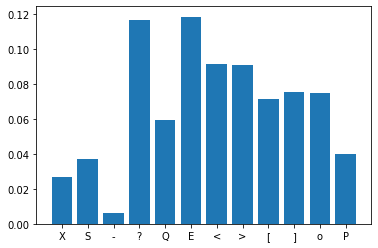

In [61]:
plt.bar(np.unique(tile_idx_errors), np.bincount(tile_idx_errors) / np.bincount(original_int.flatten()))
plt.xticks(np.unique(tile_idx_errors), [int2char_smb[i] for i in np.unique(tile_idx_errors)])
plt.show()

In [62]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [63]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [64]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [65]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(2698, 2698)

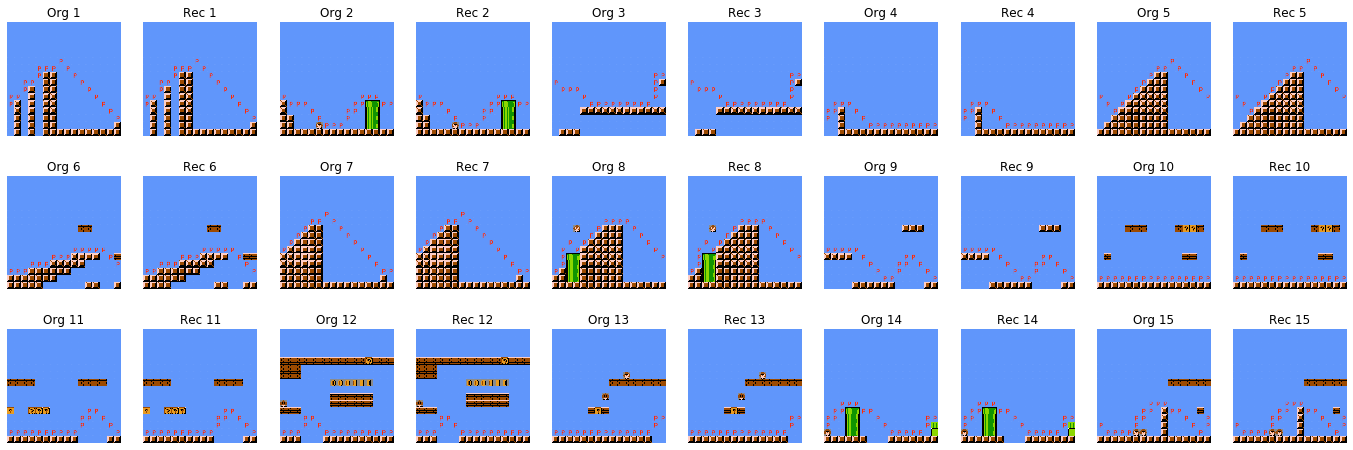

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

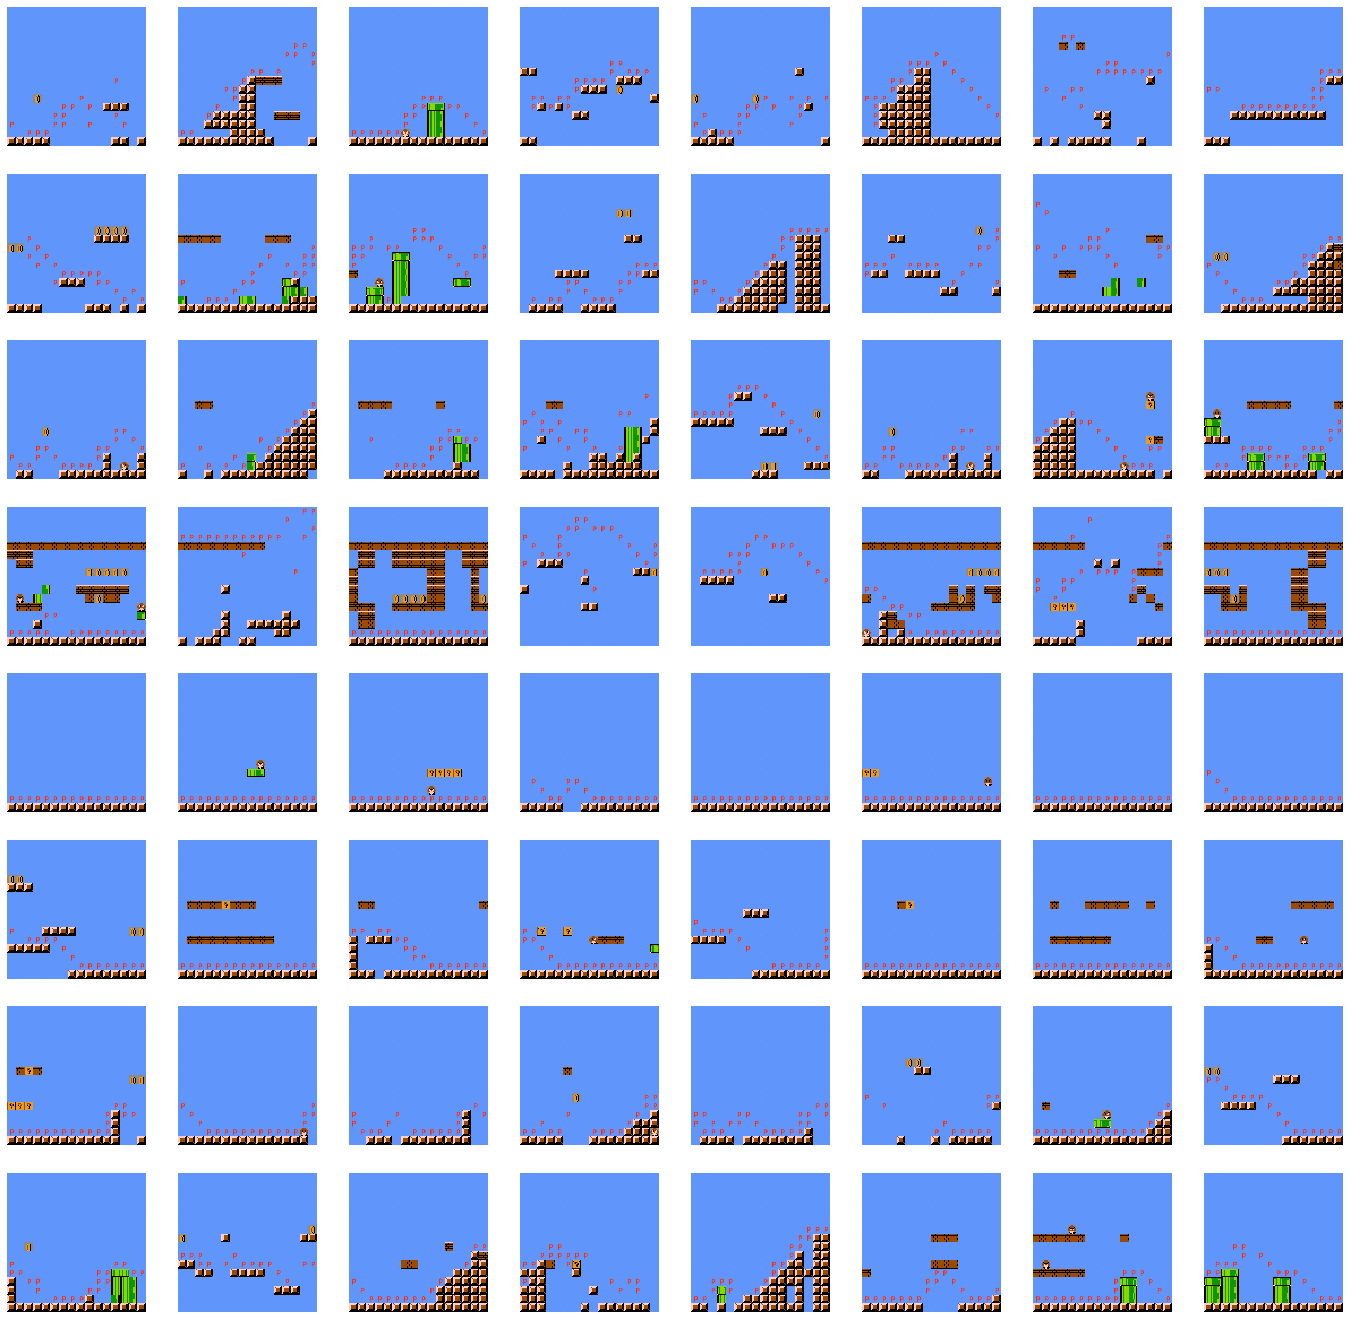

In [67]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 8
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [83]:
elem_per_category = 10000 // 8
generated = gmvae.random_generation(elem_per_category)

In [84]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [85]:
generated_int.shape

(10000, 16, 16)

In [86]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_8_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [75]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [76]:
np.bincount(test_labels)

array([329, 304, 330, 436, 199, 257, 272, 301])

In [77]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [78]:
test_labels_subset = test_labels[:first_n]

In [79]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

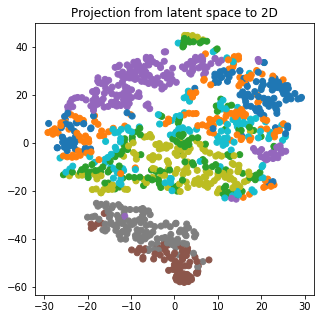

In [81]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='tab10')

plt.title('Projection from latent space to 2D')
plt.show()